In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install silence_tensorflow
!pip install pycm
!pip install lime
!pip install transformers
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp37-none-any.whl size=3743 sha256=b9ebf5e5289f9bdeb5fd9897247b6c22ef836fece5e816f21dfeed0e06af25de
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 573kB 25.9MB/s 
     |████████████████████████████████| 276kB 18.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=bb6ad0b994240ab6fc5d4a055e7b2471a33e2c6995fe8cd600c3bc82166ae7fd
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.0MB 16.1MB/s 
     |████████████████████████████████| 890kB 56.6MB/s 
     |████████████████████████████████| 3.2MB 48.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-no

True

In [4]:
import os
default_path = "/content/gdrive/MyDrive/Colab Notebooks/Automatic Software Artifacts"
os.chdir(default_path)

In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, LSTM, SpatialDropout1D, Input, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import nltk
import re
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pycm import *
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import layers, preprocessing as kprocessing
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
## for bert language model
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB

from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

import utils_functions as uf

import matplotlib as mpl
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "k", "c"]) 

np.random.seed(7)

### Some Utils Functions

In [6]:
# '''
# Compute different text length metrics.
# :parameter
#     :param dtf: dataframe - dtf with a text column
#     :param column: string - name of column containing text
# :return
#     dtf: input dataframe with 2 new columns
# '''
def add_text_length(dtf, column):
    dtf['word_count'] = dtf[column].apply(lambda x: len(str(x).split(" ")))
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(str(x).split(".")))
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf

In [8]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def display_closestwords_tsnescatterplot(word_vect, dim, words):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]
    
    # add the vector for each of the closest words to the array
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([word_vect[word]]), axis=0)
        close_words +=model.similar_by_word(word)
        
    for wrd_score in close_words:
        wrd_vector = word_vect[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
def tsne_plot(word_vect, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(word_vect[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### Read and Show a Data Sample

In [10]:
file = 'aug_original_dataset.csv'
df = pd.read_csv(file,encoding='ISO-8859-1')

In [11]:
df.sample(5)

,Label,Text
248,List of Contributors,unisys s par drivers m ben romer sparmaintaine...
245,List of Contributors,list of maintainers and how to submit kernel c...
193,Release Notes,changes since the graph now has colors there a...
145,Contributors' Guide,contributing guidelines and agreement before c...
98,License,the mit license copyright c automattic dev clo...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    441 non-null    object
 1   Label   441 non-null    object
dtypes: object(2)
memory usage: 7.0+ KB


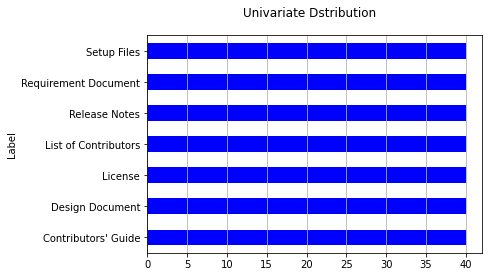

In [12]:
fig, ax = plt.subplots()
fig.suptitle("Univariate Dstribution", fontsize=12)
df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Feature Engineering - Tf-Idf (advanced variant of BoW)

In [13]:
# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

### Create the feature matrix

In [14]:
corpus = df["Text"]
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

# sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1,
#             cbar=False).set_title('Sparse Matrix Sample')

In [15]:
len(dic_vocabulary)

10000

In [16]:
# The position of a certain word (example)
word = "space"
dic_vocabulary[word]

7677

### Feature Selection
In order to drop some columns and reduce the matrix dimensionality:
  1. Treat each category as binary (for example, the “Design Document” category is 1 and 0 for the others);  
  2. Perform a Chi-Square test to determine whether a feature and the (binary) target are independent;  
  3. keep only the features with a certain p-value from the Chi-Square test.

In [17]:
y = df["Label"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.9
df_features = pd.DataFrame()
print("Initial dimension", len(X_names))
# perform a Chi-Square test to determine whether a feature and the (binary) target are independent
# keep only the features with a certain p-value from the Chi-Square test.
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "Label":cat}))
    df_features = df_features.sort_values(["Label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()
print("Final dimension", len(X_names))

Initial dimension 10000
Final dimension 563


### Selected Features Sample

In [18]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(df_features[df_features["Label"]==cat]))
   print("  . top features:", ",".join(
df_features[df_features["Label"]==cat]["feature"].values[:10]))
   print(" ")

# Contributors' Guide:
  . selected features: 46
  . top features: pull,pull request,mechanize,tests,request,selenium,systemtap,pull requests,contributing,issue
 
# Design Document:
  . selected features: 54
  . top features: design,this directory,patterns,messageloggerscribe,messageloggerq,item,pop,em,foo,autoexception
 
# License:
  . selected features: 268
  . top features: the software,software,or,copyright,license,shall,the license,this license,conditions,notice
 
# List of Contributors:
  . selected features: 71
  . top features: com,martin,maintained,gmail,gmail com,chris,net,drivers,original authors,de
 
# Release Notes:
  . selected features: 33
  . top features: fixed,now,added,gitx,fix,view,commit view,changes,can now,johannes
 
# Requirement Document:
  . selected features: 49
  . top features: mount,speakup,markers,column,blocks,pohmelfs,uml,codec,marker,servers
 
# Setup Files:
  . selected features: 44
  . top features: grunt,docker,mock,grunt contrib,contrib,person cz,c

### Refit and Reduce Dimensionality

Text(0.5, 1.0, 'Sparse Matrix Sample')

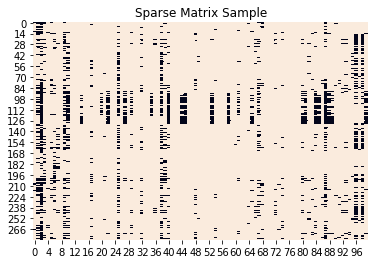

In [19]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0,
            vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

### Create Target Clusters

In [ ]:
df_features.sample(5)

,feature,score,Label
7712,run test,0.929902,Contributors' Guide
8979,term,0.999878,License
9471,util,0.953540,Setup Files
677,call,0.904592,Design Document
7214,public,0.996176,License


In [20]:
y=df["Label"].values
dic_clusters = {}
for t in np.unique(y):
    dic_clusters[t] = [word for word in df_features[df_features["Label"]==t]["feature"].tolist() if word_vect.vocab.get(word)]

for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

NameError: ignored

In [ ]:
'''
Plot word clusters in vector space (2d or 3d).
:parameter
    :param dic_words: dict - {0:lst_words, 1:lst_words, ...}
    :param nlp: gensim model
    :param plot_type: string - "2d" or "3d"
    :param annotate: bool - include word text
'''
def plot_w2v_cluster(dic_words=None, nlp=None, plot_type="2d", annotate=True, figsize=(10,5)):
    nlp = nlp
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Word Clusters", fontsize=12)
    try:
        ## word embedding
        tot_words = [word for v in dic_words.values() for word in v]
        X = nlp[tot_words]
        
        ## pca
        pca = manifold.TSNE(perplexity=40, n_components=int(plot_type[0]), init='pca')
        X = pca.fit_transform(X)

        ## create dtf
        columns = ["x","y"] if plot_type == "2d" else ["x","y","z"]
        dtf = pd.DataFrame()
        for k,v in dic_words.items():
            size = len(dtf) + len(v)
            dtf_group = pd.DataFrame(X[len(dtf):size], columns=columns, index=v)
            dtf_group["cluster"] = k
            dtf = dtf.append(dtf_group)
            
        ## plot 2d
        if plot_type == "2d": 
            ax = fig.add_subplot()
            sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
#             ax.legend().texts[0].set_text(None)
            ax.legend()
            ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
            if annotate is True:
                for i in range(len(dtf)):
                    ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
                                xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
        
        ## plot 3d
        elif plot_type == "3d":
            from mpl_toolkits.mplot3d import Axes3D
            ax = fig.add_subplot(111, projection='3d')
            colors = sns.color_palette(None, len(dic_words.keys()))
            for n,k in enumerate(dic_words.keys()):
                ax.scatter(dtf[dtf["cluster"]==k]['x'], dtf[dtf["cluster"]==k]['y'], dtf[dtf["cluster"]==k]['z'], c=colors[n], label=k)
            ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
            ax.legend()
            if annotate is True:
                for label, row in dtf[["x","y","z"]].iterrows():
                    x, y, z = row
                    ax.text(x, y, z, s=label)
        
        plt.show()
    
    except Exception as e:
        print("--- got error ---")
        print(e)
        word = str(e).split("'")[1]
        print("maybe you are looking for ... ")
        print([k for k in list(nlp.vocab.keys()) if 1-nltk.jaccard_distance(set(word),set(k)) > 0.7])

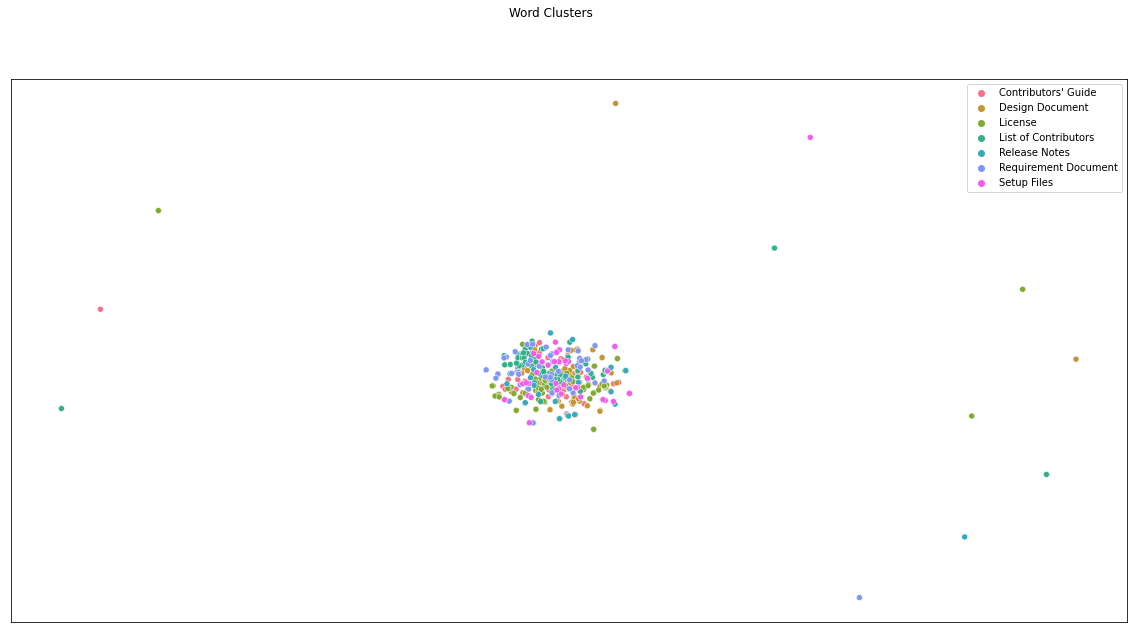

In [ ]:
plot_w2v_cluster(dic_clusters, word_vect, plot_type="2d", annotate=False, figsize=(20,10))

### Train and Test a Model

In [21]:
# Model Design
clf1 = svm.SVC(gamma='scale')
clf2 = RandomForestClassifier(n_estimators=500, random_state=1)
clf3 = MultinomialNB(alpha=0.01)
clf4 = DecisionTreeClassifier(random_state=0, max_depth=500)

svc = SVC(probability=True, kernel='linear')
ada = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)
ada2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")
ada3 = AdaBoostClassifier()
rf = RandomForestClassifier(max_depth=100, n_estimators=100, max_features=10)
nb = naive_bayes.MultinomialNB(alpha=0.01)
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', class_weight='balanced', C=1500)
dt = DecisionTreeClassifier(max_depth=500)

In [22]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        # train classifier
        model = nb.fit(X_train, y_train)
        predicted = model.predict(X_test)
        predicted_prob = model.predict_proba(X_test)
        accr = metrics.accuracy_score(y_test, predicted)

        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accrs.append(accr)
        preds.append(predicted)

    print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
-------------------------------------------
Iteração: 2 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
-------------------------------------------
Iteração: 3 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
-------------------------------------------
Iteração: 4 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
-------------------------------------------
Iteração: 5 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
-------------------------------------------
Iteração: 6 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
-------------------------------------------
Iteração: 7 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
-------------------------------------------
Iteração: 8 Fold: 10 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9321428571428572
------------

In [23]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.9321428571428572


### Evaluate

#### Plot metrics resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Setup Files         	       1.0	       1.0	       1.0	       1.0	       1.0
Requirement Document	       1.0	       1.0	       1.0	       1.0	       1.0
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	       1.0	       1.0	       1.0	       1.0	       1.0
Release Notes       	       1.0	       1.0	       1.0	       1.0	       1.0

Micro Average       	       1.0	       1.0	       1.0	       1.0	       1.0
Macro Average       	       1.0	       1.0	       1.0	       1.0	       1.0


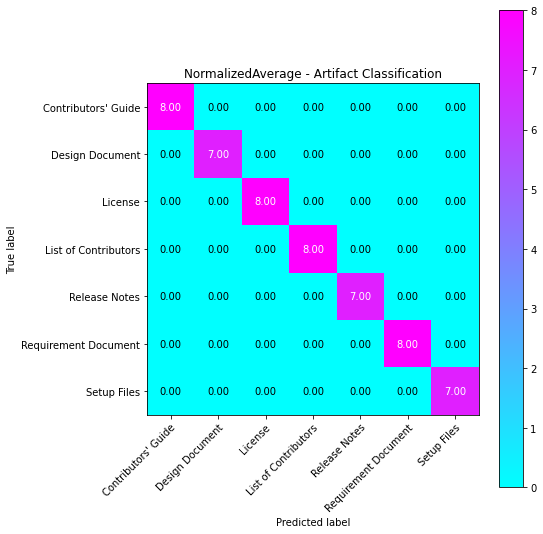

In [24]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## SO-Word2Vec

### Loading the model (SO-Word2Vec)
A word2vec model trained on Stack Overflow posts

In [25]:
from gensim.models.keyedvectors import KeyedVectors

word_vect = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)
vocab_obj = word_vect.vocab["word"]
vocab_obj.count

1786558

In [26]:
# Verifica se a palavra "upload" faz parte do vocábulo
'upload' in word_vect.vocab # Check if "upload" is in w2v vacabulary

True

### A Word and its Context (3D)

# word_vect.most_similar(word, topn=20)

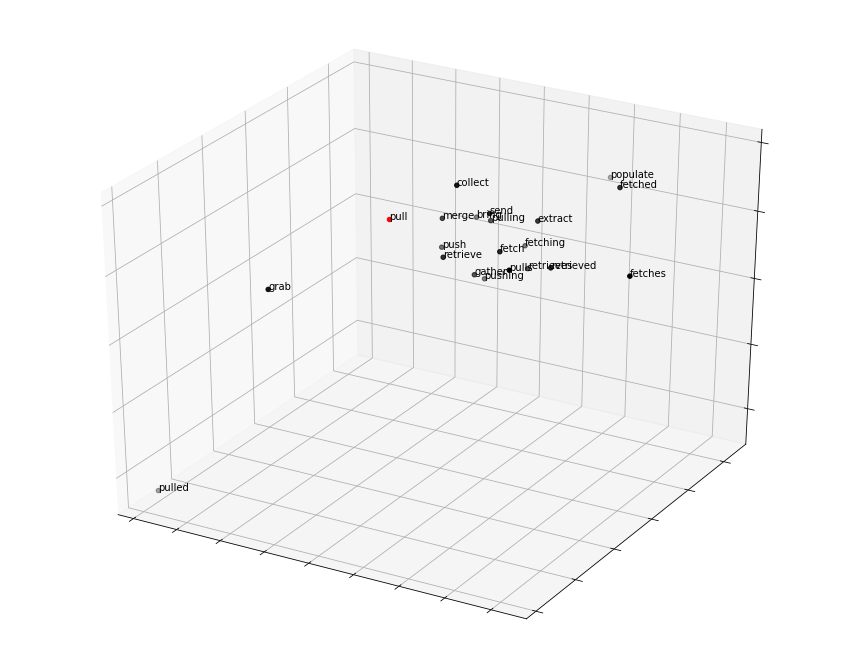

In [ ]:
word = "pull"
fig = plt.figure(figsize=(15,12))
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 word_vect.most_similar(word, topn=20)]
X = word_vect[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dataframe
dt_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dt_["input"] = 0
dt_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dt_[dt_["input"]==0]['x'], 
           dt_[dt_["input"]==0]['y'], 
           dt_[dt_["input"]==0]['z'], c="black")
ax.scatter(dt_[dt_["input"]==1]['x'], 
           dt_[dt_["input"]==1]['y'], 
           dt_[dt_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dt_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### Most similar word (top n=3)

In [27]:
word = "pull"
tot_words = [word] + [tupla[0] for tupla in 
                 word_vect.most_similar(word, topn=3)]
tot_words

['pull', 'fetch', 'pulling', 'pulled']

### Feature Engineer

In [28]:
corpus = df["Text"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

### Transform the Corpus into Padded Sequences

In [29]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=50, padding="post", truncating="post")

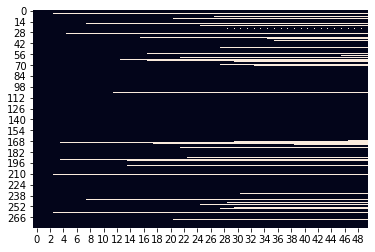

In [30]:
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Create the Matrix of Embedding

In [31]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 200))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  word_vect[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [33]:
#It can be navigated by word id, which can be obtained from the vocabulary.upward 6369
word = "request"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]], 
      "|vector")

dic[word]: 349 |idx
embeddings[idx]: [ 1.71501172  0.7852335   1.311046    1.25057197  1.65266156 -0.8331086
  1.84451008 -4.96892977 -0.6787107   6.1716423  -1.64291453 -3.02143598
 -0.58511001 -0.71621716 -3.2047801   2.03092623 -2.34295559  2.03590012
 -3.8842783   0.04692687  1.5119735  -1.9776963  -0.04969407 -0.50642586
 -0.06627674  1.77656829  1.35233438  4.18535233 -1.46803296 -0.65645576
 -0.26029998  2.91771436  1.48479784  1.81747878 -3.46237516  0.1559162
 -0.95599455 -0.15077835  6.23126078 -1.38241363 -3.87634897  3.71742439
 -0.65316492  1.56681883 -0.04411846 -0.46480507 -1.7285974   1.0327332
  0.20037037 -0.57795542  5.92800522  0.93197703 -1.48425066  1.71014106
 -0.38004711 -0.66866654 -3.62485075 -0.8776831   1.75564611 -0.89732385
  1.26538134  0.46205983 -0.89672291 -1.42767894 -1.12906623 -4.46481228
  0.5937649   1.70277834  0.67582816 -0.54015571  1.17177761 -2.95459199
  3.13196445  2.14433193  0.14853998  0.43420106  3.85590434 -0.51182818
 -1.18221354 -1.5

In [34]:
embeddings.shape

(17101, 200)

### Covered Vocabulary

In [35]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embeddings, axis=1))
nonzero_elements / len(word_vect.wv.vocab)

0.007443716094664954

### Deep Learning Model

In [45]:
from tensorflow.keras.constraints import max_norm
def fit_bert_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, epochs=1, batch_size=16):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    # print(dic_y_mapping)
    
    ## model
    if model is None:
        # input
        x_in = layers.Input(shape=(X_train.shape[1],))

        # embedding
        X = layers.Embedding(input_dim=embeddings.shape[0],  
                              output_dim=embeddings.shape[1], 
                              weights=[embeddings],
                              input_length=X_train.shape[1], trainable=True)(x_in)

        # 2 layers of bidirectional lstm
        X = layers.Bidirectional(layers.LSTM(180, 
                              return_sequences=True))(X)
        X = layers.Bidirectional(layers.LSTM(90))(X)
        X = layers.Dropout(0.3)(X)

        # ## final dense layers
#         X = layers.Dense(32, activation='tanh', kernel_constraint=max_norm(11))(X)
        X = layers.Dense(512, activation='relu')(X)

        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(X)

        model = Model(x_in, y_out)
        ## compile
        model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='nadam', metrics=['accuracy'])
        # print(model.summary())
        
    ## train
    verbose = 1 if epochs > 1 else 2
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.2)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted

'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

### Define Target

In [37]:
y = df["Label"].values

### Train the Model

Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7802 - accuracy: 0.3694 - val_loss: 0.9209 - val_accuracy: 0.7556
Epoch 2/10
23/23 [==============================] - 1s 42ms/step - loss: 0.5448 - accuracy: 0.8866 - val_loss: 0.9744 - val_accuracy: 0.6667
Epoch 3/10
23/23 [==============================] - 1s 42ms/step - loss: 0.2344 - accuracy: 0.9552 - val_loss: 0.6525 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0646 - accuracy: 0.9884 - val_loss: 0.5957 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0313 - accuracy: 0.9886 - val_loss: 0.6575 - val_accuracy: 0.7556
Epoch 6/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.6627 - val_accuracy: 0.7556
Epoch 7/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.6631 - val_accuracy: 0.7556
Epoch 8/10
23

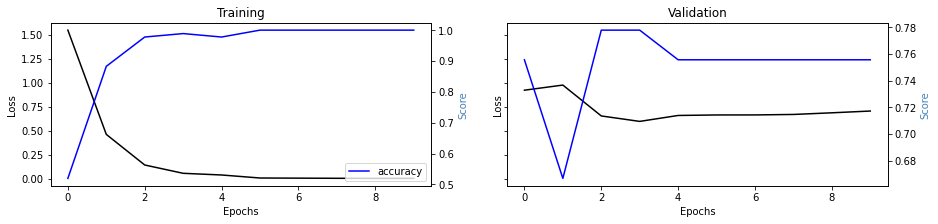

Iteração: 1 Fold: 1 Accuracy: 0.875, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 92ms/step - loss: 1.7593 - accuracy: 0.3715 - val_loss: 1.0043 - val_accuracy: 0.6444
Epoch 2/10
23/23 [==============================] - 1s 41ms/step - loss: 0.5649 - accuracy: 0.7878 - val_loss: 0.4229 - val_accuracy: 0.9111
Epoch 3/10
23/23 [==============================] - 1s 41ms/step - loss: 0.1366 - accuracy: 0.9735 - val_loss: 0.3685 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.3280 - val_accuracy: 0.9333
Epoch 5/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.3274 - val_accuracy: 0.9333
Epoch 6/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.3399 - val_accuracy: 0.8889
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0018 - accuracy: 1.00

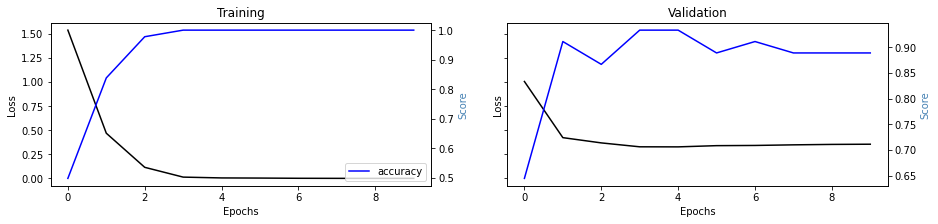

Iteração: 1 Fold: 2 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8571428571428572
Epoch 1/10
23/23 [==============================] - 7s 92ms/step - loss: 1.7660 - accuracy: 0.3355 - val_loss: 1.0851 - val_accuracy: 0.7333
Epoch 2/10
23/23 [==============================] - 1s 40ms/step - loss: 0.4821 - accuracy: 0.9329 - val_loss: 0.7519 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 38ms/step - loss: 0.1301 - accuracy: 0.9746 - val_loss: 0.8580 - val_accuracy: 0.7111
Epoch 4/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0386 - accuracy: 0.9912 - val_loss: 0.8263 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 39ms/step - loss: 0.0188 - accuracy: 0.9933 - val_loss: 0.8929 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 1.0265 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - los

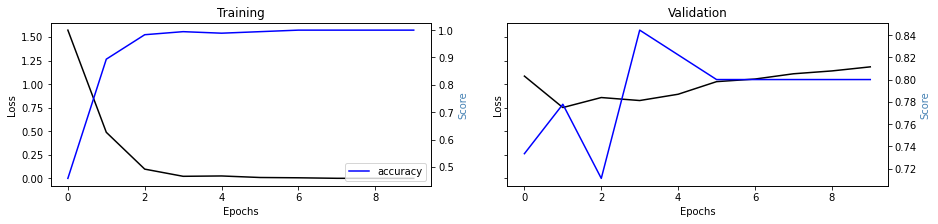

Iteração: 1 Fold: 3 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8571428571428572
Epoch 1/10
23/23 [==============================] - 7s 89ms/step - loss: 1.7225 - accuracy: 0.4602 - val_loss: 1.1825 - val_accuracy: 0.6000
Epoch 2/10
23/23 [==============================] - 1s 41ms/step - loss: 0.4948 - accuracy: 0.8670 - val_loss: 0.7979 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0997 - accuracy: 0.9795 - val_loss: 0.7898 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0655 - accuracy: 0.9756 - val_loss: 1.0740 - val_accuracy: 0.7111
Epoch 5/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.9064 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.9448 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - los

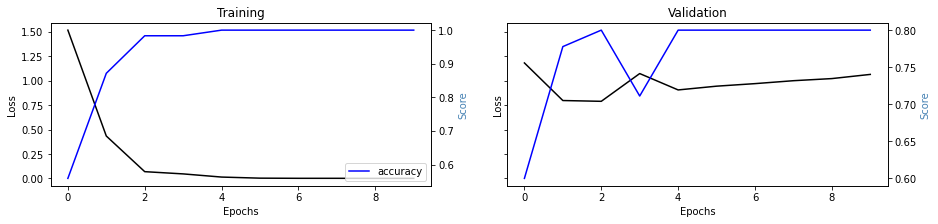

Iteração: 1 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8392857142857143
Epoch 1/10
23/23 [==============================] - 7s 92ms/step - loss: 1.7713 - accuracy: 0.3543 - val_loss: 1.1052 - val_accuracy: 0.5111
Epoch 2/10
23/23 [==============================] - 1s 42ms/step - loss: 0.6076 - accuracy: 0.7989 - val_loss: 0.4194 - val_accuracy: 0.8444
Epoch 3/10
23/23 [==============================] - 1s 43ms/step - loss: 0.1100 - accuracy: 0.9831 - val_loss: 0.3972 - val_accuracy: 0.8889
Epoch 4/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0323 - accuracy: 0.9898 - val_loss: 0.4155 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0093 - accuracy: 0.9985 - val_loss: 0.5244 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.5225 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - los

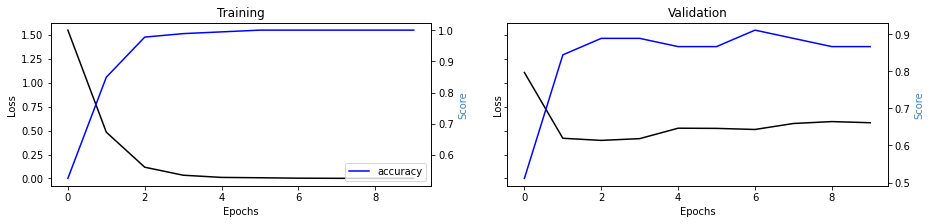

Iteração: 1 Fold: 5 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8535714285714286
Epoch 1/10
23/23 [==============================] - 7s 91ms/step - loss: 1.7694 - accuracy: 0.4111 - val_loss: 0.9187 - val_accuracy: 0.7556
Epoch 2/10
23/23 [==============================] - 1s 38ms/step - loss: 0.4846 - accuracy: 0.9199 - val_loss: 0.6682 - val_accuracy: 0.7556
Epoch 3/10
23/23 [==============================] - 1s 37ms/step - loss: 0.1661 - accuracy: 0.9663 - val_loss: 0.4869 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 40ms/step - loss: 0.0563 - accuracy: 0.9837 - val_loss: 0.4118 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0604 - accuracy: 0.9803 - val_loss: 0.4241 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 38ms/step - loss: 0.0096 - accuracy: 0.9965 - val_loss: 0.5297 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - los

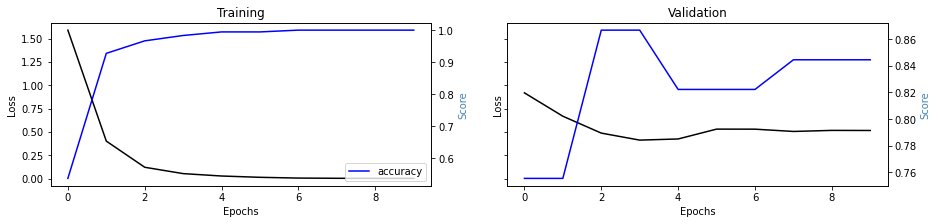

Iteração: 1 Fold: 6 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8601190476190478
Epoch 1/10
23/23 [==============================] - 9s 92ms/step - loss: 1.7722 - accuracy: 0.3331 - val_loss: 1.0376 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 42ms/step - loss: 0.5909 - accuracy: 0.8652 - val_loss: 0.3435 - val_accuracy: 0.8889
Epoch 3/10
23/23 [==============================] - 1s 40ms/step - loss: 0.1223 - accuracy: 0.9652 - val_loss: 0.2913 - val_accuracy: 0.9333
Epoch 4/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0530 - accuracy: 0.9917 - val_loss: 0.3102 - val_accuracy: 0.9111
Epoch 5/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0285 - accuracy: 0.9899 - val_loss: 0.3034 - val_accuracy: 0.9111
Epoch 6/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.3036 - val_accuracy: 0.9111
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - los

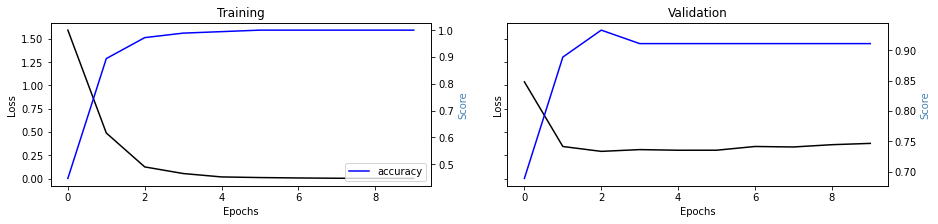

Iteração: 1 Fold: 7 Accuracy: 0.9464285714285714, Mean Accuracy: 0.8724489795918368
Epoch 1/10
23/23 [==============================] - 7s 93ms/step - loss: 1.7332 - accuracy: 0.4077 - val_loss: 0.8956 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.5277 - accuracy: 0.8666 - val_loss: 0.7423 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.1355 - accuracy: 0.9724 - val_loss: 0.4997 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.5281 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5427 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - los

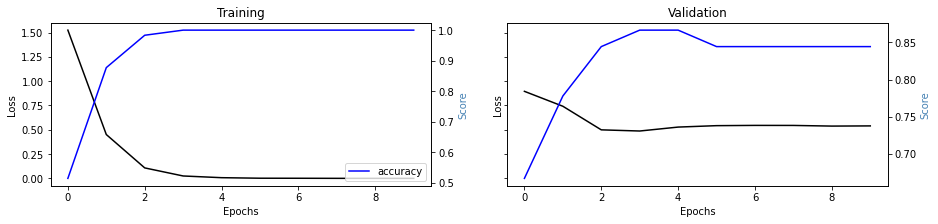

Iteração: 1 Fold: 8 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8750000000000001
Epoch 1/10
23/23 [==============================] - 7s 94ms/step - loss: 1.7338 - accuracy: 0.4115 - val_loss: 0.8906 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 43ms/step - loss: 0.5262 - accuracy: 0.8784 - val_loss: 0.6584 - val_accuracy: 0.7111
Epoch 3/10
23/23 [==============================] - 1s 43ms/step - loss: 0.1337 - accuracy: 0.9615 - val_loss: 0.6671 - val_accuracy: 0.7111
Epoch 4/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0335 - accuracy: 0.9909 - val_loss: 0.7538 - val_accuracy: 0.7333
Epoch 5/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0117 - accuracy: 0.9976 - val_loss: 0.6809 - val_accuracy: 0.7778
Epoch 6/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.7506 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 42ms/step - los

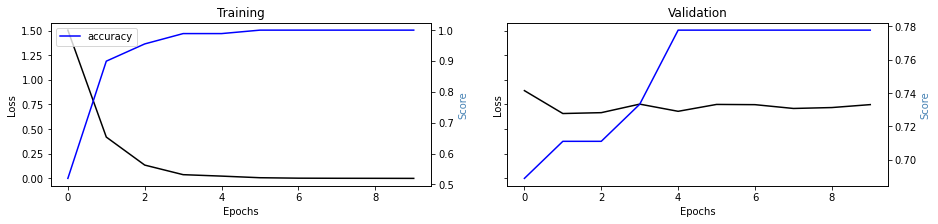

Iteração: 1 Fold: 9 Accuracy: 0.875, Mean Accuracy: 0.8750000000000001
Epoch 1/10
23/23 [==============================] - 7s 94ms/step - loss: 1.7180 - accuracy: 0.3504 - val_loss: 1.0951 - val_accuracy: 0.6444
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.5669 - accuracy: 0.8354 - val_loss: 0.5521 - val_accuracy: 0.8667
Epoch 3/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0947 - accuracy: 0.9877 - val_loss: 0.8185 - val_accuracy: 0.7333
Epoch 4/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0377 - accuracy: 0.9834 - val_loss: 0.6649 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.7167 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.7282 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0017 - a

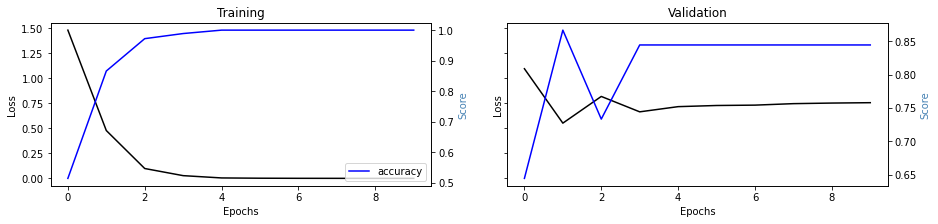

Iteração: 1 Fold: 10 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8714285714285716
Epoch 1/10
23/23 [==============================] - 9s 94ms/step - loss: 1.7553 - accuracy: 0.3685 - val_loss: 1.0280 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.5937 - accuracy: 0.8942 - val_loss: 0.4456 - val_accuracy: 0.8889
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0904 - accuracy: 0.9811 - val_loss: 0.5526 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0239 - accuracy: 0.9956 - val_loss: 0.4994 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.5076 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5137 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 41ms/step - lo

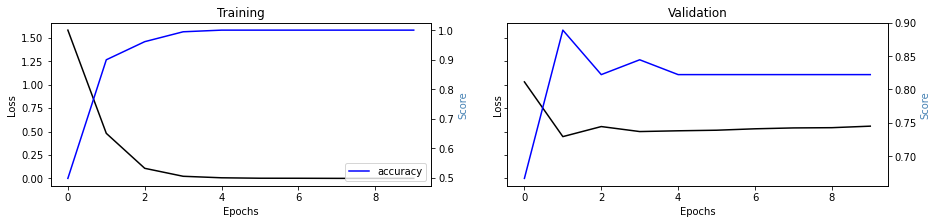

Iteração: 2 Fold: 1 Accuracy: 0.9107142857142857, Mean Accuracy: 0.9107142857142857
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7404 - accuracy: 0.4093 - val_loss: 0.8047 - val_accuracy: 0.8667
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.4966 - accuracy: 0.8906 - val_loss: 0.8727 - val_accuracy: 0.7111
Epoch 3/10
23/23 [==============================] - 1s 43ms/step - loss: 0.1786 - accuracy: 0.9500 - val_loss: 0.4459 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 0.4479 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4283 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4332 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - los

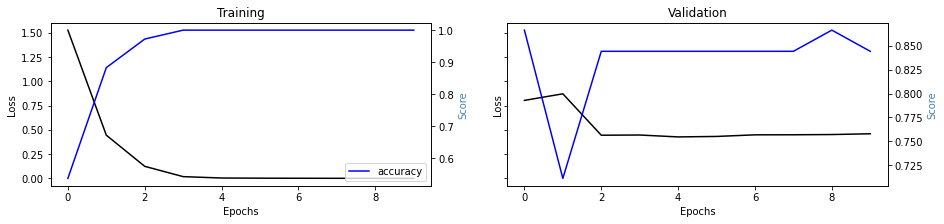

Iteração: 2 Fold: 2 Accuracy: 0.8392857142857143, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 94ms/step - loss: 1.7617 - accuracy: 0.3301 - val_loss: 1.3695 - val_accuracy: 0.5556
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.6401 - accuracy: 0.7959 - val_loss: 0.8677 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.1015 - accuracy: 0.9725 - val_loss: 0.8324 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0287 - accuracy: 0.9990 - val_loss: 1.0236 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.8497 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0400 - accuracy: 0.9850 - val_loss: 0.9168 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0123 - a

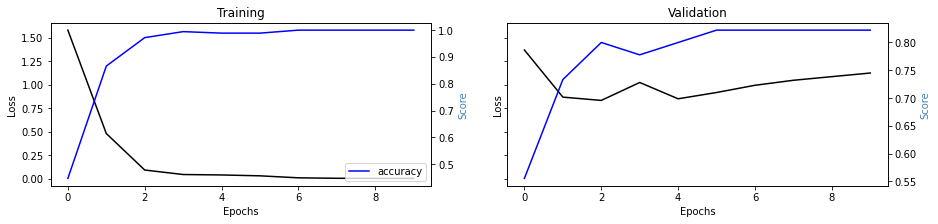

Iteração: 2 Fold: 3 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8809523809523809
Epoch 1/10
23/23 [==============================] - 8s 161ms/step - loss: 1.7117 - accuracy: 0.3880 - val_loss: 1.0097 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 43ms/step - loss: 0.4077 - accuracy: 0.9393 - val_loss: 0.7351 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0922 - accuracy: 0.9947 - val_loss: 0.7089 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0619 - accuracy: 0.9781 - val_loss: 0.6968 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.7359 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.7926 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 44ms/step - lo

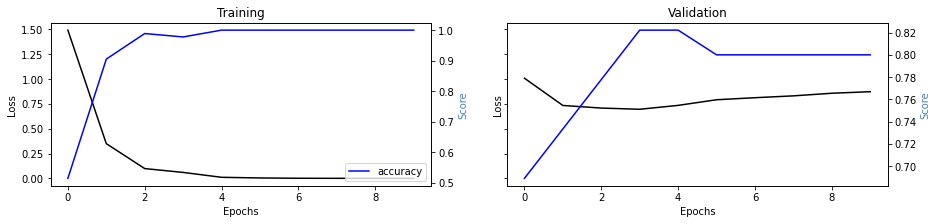

Iteração: 2 Fold: 4 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8705357142857143
Epoch 1/10
23/23 [==============================] - 7s 94ms/step - loss: 1.6918 - accuracy: 0.4107 - val_loss: 0.7973 - val_accuracy: 0.8000
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.4564 - accuracy: 0.8882 - val_loss: 0.5507 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.1645 - accuracy: 0.9559 - val_loss: 0.4322 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0628 - accuracy: 0.9876 - val_loss: 0.4415 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0257 - accuracy: 0.9925 - val_loss: 0.4547 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.5384 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 45ms/step - los

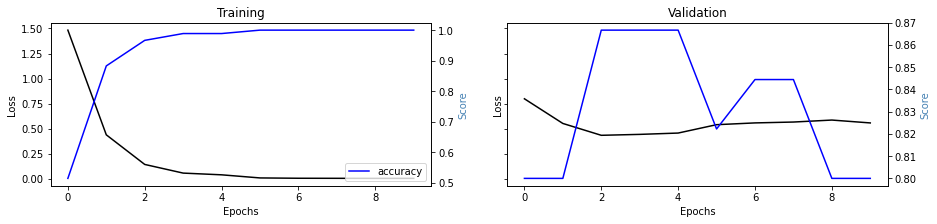

Iteração: 2 Fold: 5 Accuracy: 0.8928571428571429, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 93ms/step - loss: 1.7295 - accuracy: 0.3760 - val_loss: 0.9903 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.5130 - accuracy: 0.8898 - val_loss: 0.4559 - val_accuracy: 0.8444
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1246 - accuracy: 0.9670 - val_loss: 0.4217 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 0.4005 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.4205 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4505 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0019 - a

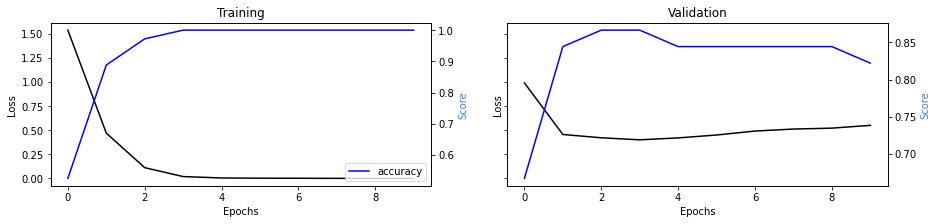

Iteração: 2 Fold: 6 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8809523809523809
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7180 - accuracy: 0.3927 - val_loss: 0.9082 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.5347 - accuracy: 0.8494 - val_loss: 0.6251 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.1773 - accuracy: 0.9950 - val_loss: 0.4401 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0267 - accuracy: 0.9972 - val_loss: 0.4565 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0318 - accuracy: 0.9972 - val_loss: 0.3283 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0074 - accuracy: 0.9988 - val_loss: 0.3489 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 45ms/step - los

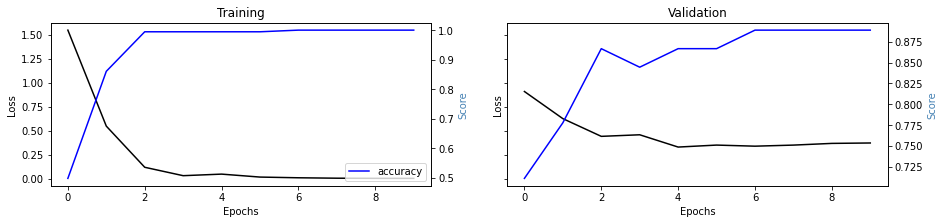

Iteração: 2 Fold: 7 Accuracy: 0.9285714285714286, Mean Accuracy: 0.8877551020408163
Epoch 1/10
23/23 [==============================] - 9s 95ms/step - loss: 1.7714 - accuracy: 0.3873 - val_loss: 0.8563 - val_accuracy: 0.8222
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.4550 - accuracy: 0.9272 - val_loss: 0.5911 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0961 - accuracy: 0.9799 - val_loss: 0.6764 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0341 - accuracy: 0.9907 - val_loss: 0.7022 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.8629 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.9289 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - los

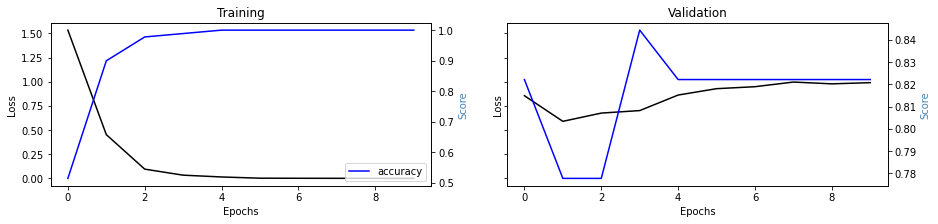

Iteração: 2 Fold: 8 Accuracy: 0.9285714285714286, Mean Accuracy: 0.8928571428571429
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7633 - accuracy: 0.3452 - val_loss: 0.8894 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.4558 - accuracy: 0.9158 - val_loss: 0.6185 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0953 - accuracy: 0.9825 - val_loss: 0.6896 - val_accuracy: 0.7333
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0649 - accuracy: 0.9948 - val_loss: 0.7015 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0534 - accuracy: 0.9875 - val_loss: 0.4812 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0113 - accuracy: 0.9985 - val_loss: 0.5857 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 44ms/step - los

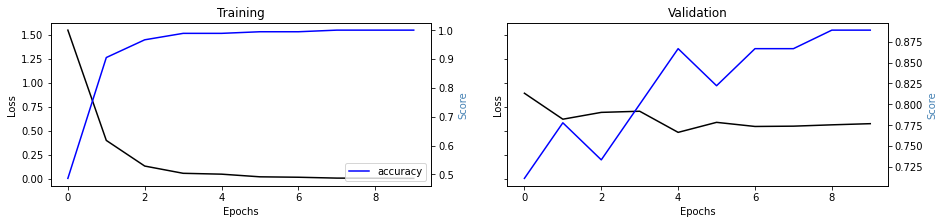

Iteração: 2 Fold: 9 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8928571428571429
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7669 - accuracy: 0.4330 - val_loss: 1.2217 - val_accuracy: 0.5333
Epoch 2/10
23/23 [==============================] - 1s 43ms/step - loss: 0.5255 - accuracy: 0.8380 - val_loss: 0.6476 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.1704 - accuracy: 0.9684 - val_loss: 0.7087 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 41ms/step - loss: 0.0547 - accuracy: 0.9960 - val_loss: 0.6414 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0524 - accuracy: 0.9658 - val_loss: 0.6650 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.6995 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 45ms/step - los

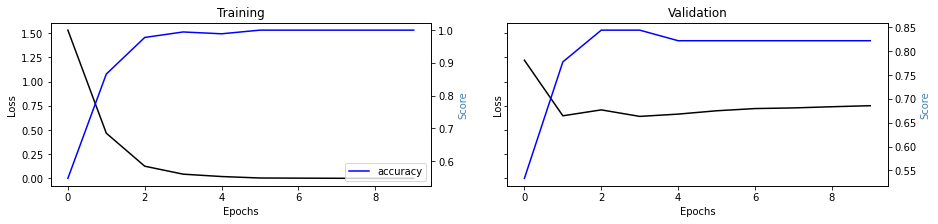

Iteração: 2 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8857142857142858
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7381 - accuracy: 0.3816 - val_loss: 1.0032 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.6068 - accuracy: 0.8924 - val_loss: 0.5205 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.1508 - accuracy: 0.9601 - val_loss: 0.4658 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0224 - accuracy: 0.9873 - val_loss: 0.5710 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0308 - accuracy: 0.9945 - val_loss: 0.4396 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0207 - accuracy: 0.9912 - val_loss: 0.4204 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 45ms/step - lo

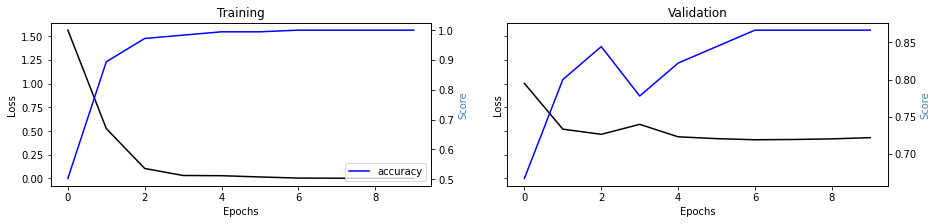

Iteração: 3 Fold: 1 Accuracy: 0.875, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7518 - accuracy: 0.3611 - val_loss: 1.0247 - val_accuracy: 0.7556
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.5943 - accuracy: 0.8639 - val_loss: 0.6743 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0855 - accuracy: 0.9634 - val_loss: 0.8001 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 47ms/step - loss: 0.1116 - accuracy: 0.9796 - val_loss: 0.5885 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0448 - accuracy: 0.9871 - val_loss: 0.6012 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.6397 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0044 - accuracy: 1.00

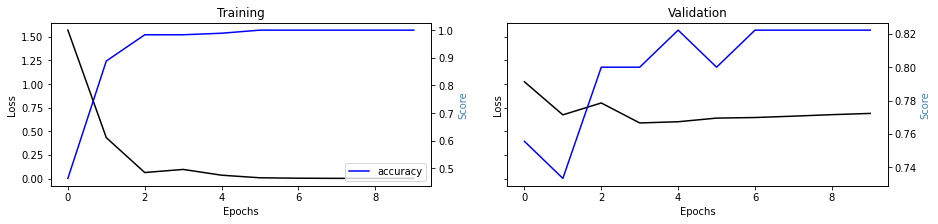

Iteração: 3 Fold: 2 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8571428571428572
Epoch 1/10
23/23 [==============================] - 7s 93ms/step - loss: 1.7414 - accuracy: 0.4409 - val_loss: 1.0135 - val_accuracy: 0.6222
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.4955 - accuracy: 0.9148 - val_loss: 0.7378 - val_accuracy: 0.6889
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.1581 - accuracy: 0.9687 - val_loss: 0.8119 - val_accuracy: 0.7556
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0384 - accuracy: 0.9846 - val_loss: 0.8873 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9353 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 42ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.0093 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 44ms/step - los

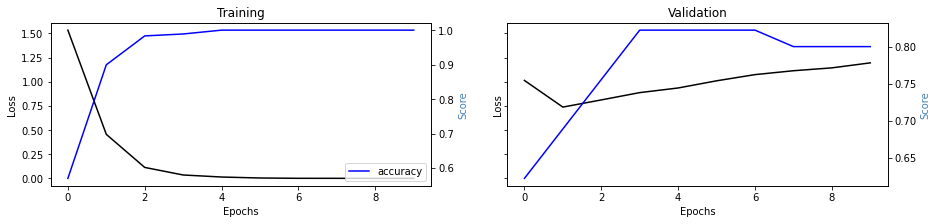

Iteração: 3 Fold: 3 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8571428571428572
Epoch 1/10
23/23 [==============================] - 7s 97ms/step - loss: 1.7333 - accuracy: 0.4497 - val_loss: 1.2512 - val_accuracy: 0.5333
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.3926 - accuracy: 0.8813 - val_loss: 1.2581 - val_accuracy: 0.5778
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.2006 - accuracy: 0.9374 - val_loss: 0.9125 - val_accuracy: 0.7111
Epoch 4/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0568 - accuracy: 0.9950 - val_loss: 1.0407 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.1221 - val_accuracy: 0.7556
Epoch 6/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.1730 - val_accuracy: 0.7556
Epoch 7/10
23/23 [==============================] - 1s 47ms/step - los

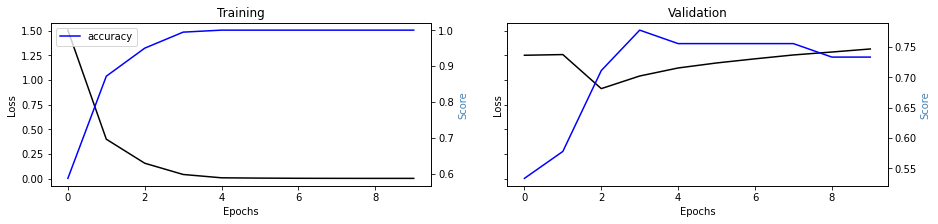

Iteração: 3 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8392857142857143
Epoch 1/10
23/23 [==============================] - 9s 97ms/step - loss: 1.7776 - accuracy: 0.4029 - val_loss: 1.0693 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.5695 - accuracy: 0.8613 - val_loss: 0.4751 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 0.1626 - accuracy: 0.9603 - val_loss: 1.0235 - val_accuracy: 0.6889
Epoch 4/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0515 - accuracy: 0.9855 - val_loss: 0.4813 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.5698 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5835 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 46ms/step - los

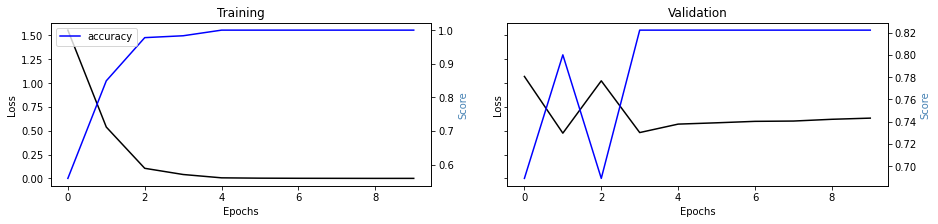

Iteração: 3 Fold: 5 Accuracy: 0.9285714285714286, Mean Accuracy: 0.8571428571428571
Epoch 1/10
23/23 [==============================] - 7s 94ms/step - loss: 1.7924 - accuracy: 0.3062 - val_loss: 1.0520 - val_accuracy: 0.6222
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.5560 - accuracy: 0.8909 - val_loss: 0.4639 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 43ms/step - loss: 0.1085 - accuracy: 0.9827 - val_loss: 0.4792 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0328 - accuracy: 0.9917 - val_loss: 0.3694 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0212 - accuracy: 1.0000 - val_loss: 0.3517 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3324 - val_accuracy: 0.9111
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - los

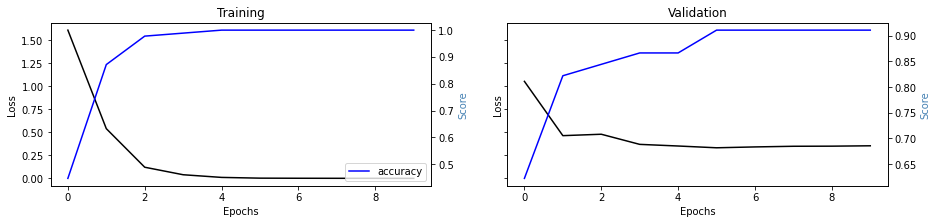

Iteração: 3 Fold: 6 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8660714285714285
Epoch 1/10
23/23 [==============================] - 7s 96ms/step - loss: 1.7657 - accuracy: 0.3380 - val_loss: 0.9373 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.5497 - accuracy: 0.8919 - val_loss: 0.4759 - val_accuracy: 0.8444
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.1090 - accuracy: 0.9990 - val_loss: 0.3787 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.3794 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0316 - accuracy: 0.9929 - val_loss: 0.4318 - val_accuracy: 0.8889
Epoch 6/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0232 - accuracy: 0.9859 - val_loss: 0.4515 - val_accuracy: 0.8889
Epoch 7/10
23/23 [==============================] - 1s 47ms/step - los

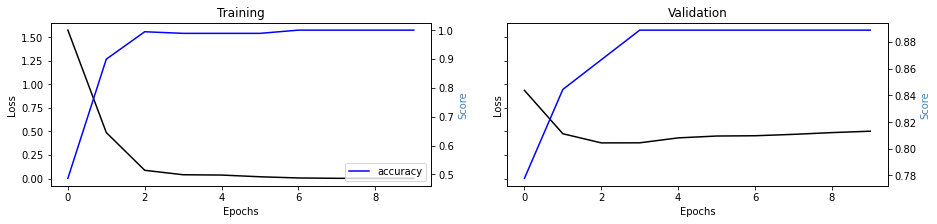

Iteração: 3 Fold: 7 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8724489795918366
Epoch 1/10
23/23 [==============================] - 7s 96ms/step - loss: 1.7260 - accuracy: 0.3558 - val_loss: 0.9607 - val_accuracy: 0.6444
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.6072 - accuracy: 0.8247 - val_loss: 0.6653 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.1203 - accuracy: 0.9781 - val_loss: 0.6944 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0484 - accuracy: 0.9854 - val_loss: 0.7643 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0451 - accuracy: 0.9825 - val_loss: 0.7302 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.6612 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 48ms/step - los

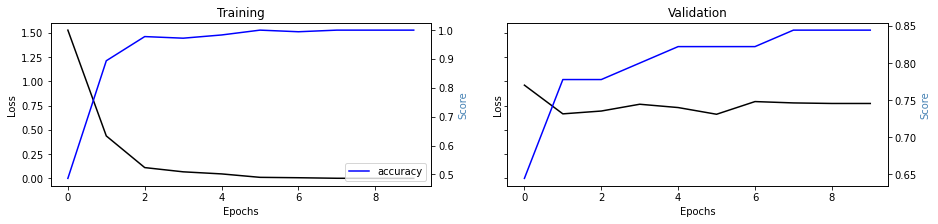

Iteração: 3 Fold: 8 Accuracy: 0.875, Mean Accuracy: 0.8727678571428571
Epoch 1/10
23/23 [==============================] - 9s 96ms/step - loss: 1.7799 - accuracy: 0.3768 - val_loss: 0.9853 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 47ms/step - loss: 0.5016 - accuracy: 0.8883 - val_loss: 0.6633 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0886 - accuracy: 0.9816 - val_loss: 0.4983 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0401 - accuracy: 0.9960 - val_loss: 0.4440 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0242 - accuracy: 0.9857 - val_loss: 0.4311 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0152 - accuracy: 0.9985 - val_loss: 0.4074 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0176 - a

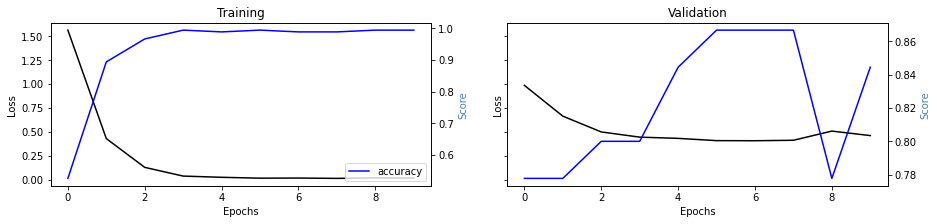

Iteração: 3 Fold: 9 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8690476190476191
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7670 - accuracy: 0.4158 - val_loss: 1.0998 - val_accuracy: 0.6444
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.6389 - accuracy: 0.8223 - val_loss: 0.7394 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.1975 - accuracy: 0.9518 - val_loss: 0.4973 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0359 - accuracy: 0.9950 - val_loss: 0.6914 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0402 - accuracy: 0.9945 - val_loss: 0.5115 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.5442 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 44ms/step - los

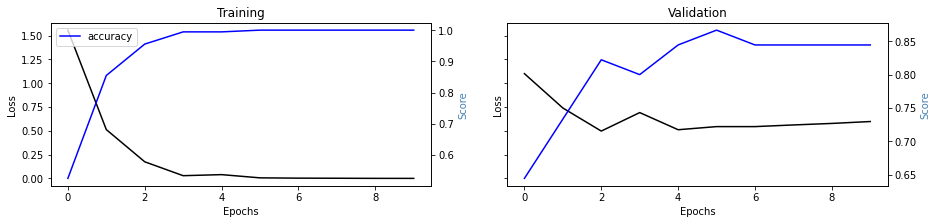

Iteração: 3 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8642857142857142
Epoch 1/10
23/23 [==============================] - 7s 97ms/step - loss: 1.7668 - accuracy: 0.3165 - val_loss: 1.0081 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 0.5786 - accuracy: 0.8254 - val_loss: 0.8527 - val_accuracy: 0.7556
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.1431 - accuracy: 0.9481 - val_loss: 0.4683 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0182 - accuracy: 0.9985 - val_loss: 0.6808 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0217 - accuracy: 0.9965 - val_loss: 0.5620 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.5475 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 42ms/step - lo

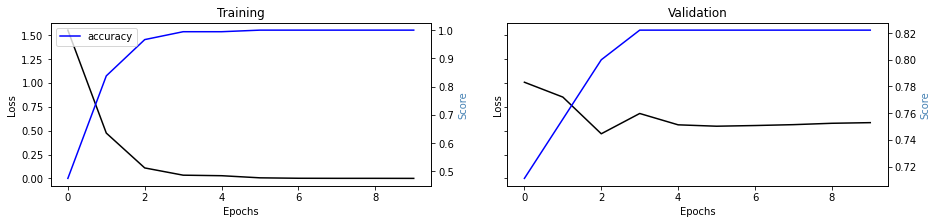

Iteração: 4 Fold: 1 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8928571428571429
Epoch 1/10
23/23 [==============================] - 7s 94ms/step - loss: 1.7467 - accuracy: 0.3272 - val_loss: 0.9249 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.5070 - accuracy: 0.8943 - val_loss: 0.5558 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0881 - accuracy: 0.9748 - val_loss: 0.7713 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0662 - accuracy: 0.9764 - val_loss: 0.4539 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.4782 - val_accuracy: 0.8889
Epoch 6/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4924 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 46ms/step - los

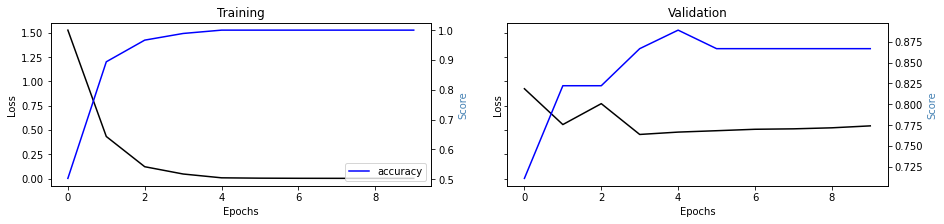

Iteração: 4 Fold: 2 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8571428571428572
Epoch 1/10
23/23 [==============================] - 7s 96ms/step - loss: 1.7946 - accuracy: 0.3777 - val_loss: 1.1219 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.5487 - accuracy: 0.8853 - val_loss: 0.5982 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1154 - accuracy: 0.9674 - val_loss: 0.7784 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0463 - accuracy: 0.9850 - val_loss: 0.7704 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0218 - accuracy: 0.9940 - val_loss: 0.7906 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 0.0221 - accuracy: 0.9922 - val_loss: 0.8706 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 47ms/step - los

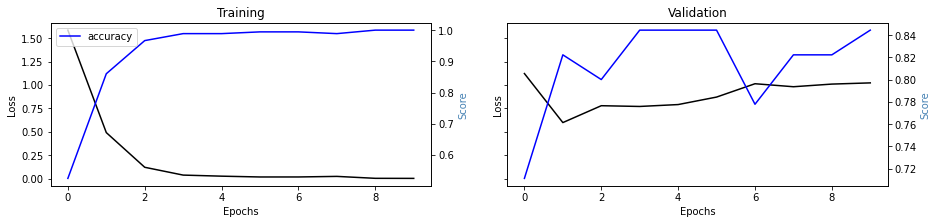

Iteração: 4 Fold: 3 Accuracy: 0.9464285714285714, Mean Accuracy: 0.8869047619047619
Epoch 1/10
23/23 [==============================] - 7s 97ms/step - loss: 1.7059 - accuracy: 0.4490 - val_loss: 0.9941 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.4228 - accuracy: 0.9046 - val_loss: 0.7566 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0934 - accuracy: 0.9829 - val_loss: 0.7774 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0800 - accuracy: 0.9881 - val_loss: 0.7896 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0312 - accuracy: 0.9884 - val_loss: 0.7898 - val_accuracy: 0.7778
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0550 - accuracy: 0.9834 - val_loss: 0.8754 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 47ms/step - los

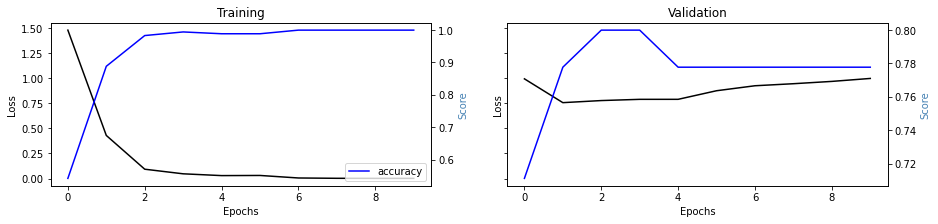

Iteração: 4 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8616071428571428
Epoch 1/10
23/23 [==============================] - 7s 97ms/step - loss: 1.7682 - accuracy: 0.3244 - val_loss: 1.0770 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.6169 - accuracy: 0.8744 - val_loss: 0.4223 - val_accuracy: 0.8667
Epoch 3/10
23/23 [==============================] - 1s 45ms/step - loss: 0.0888 - accuracy: 0.9871 - val_loss: 0.4313 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.4048 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.3906 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.3854 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 47ms/step - los

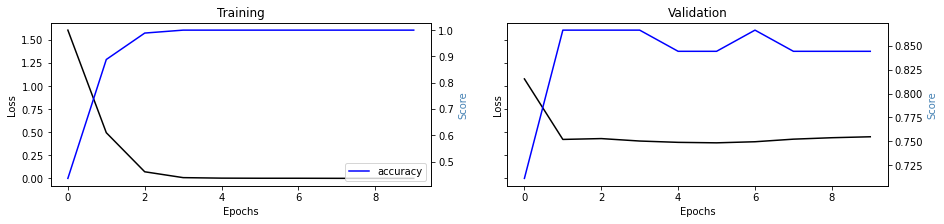

Iteração: 4 Fold: 5 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8714285714285713
Epoch 1/10
23/23 [==============================] - 9s 97ms/step - loss: 1.8324 - accuracy: 0.3223 - val_loss: 0.9707 - val_accuracy: 0.8000
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.5881 - accuracy: 0.9138 - val_loss: 0.4462 - val_accuracy: 0.8667
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1132 - accuracy: 0.9838 - val_loss: 0.4163 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0210 - accuracy: 0.9964 - val_loss: 0.4743 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0481 - accuracy: 0.9931 - val_loss: 0.3696 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0126 - accuracy: 0.9976 - val_loss: 0.3734 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 46ms/step - los

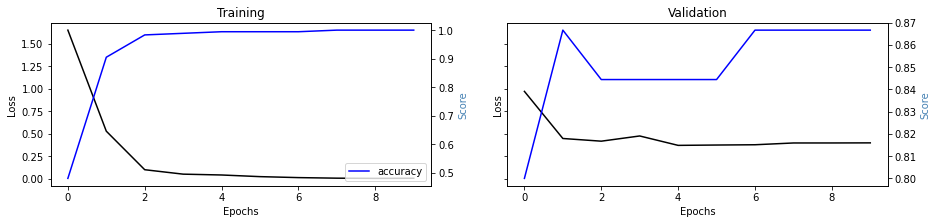

Iteração: 4 Fold: 6 Accuracy: 0.9285714285714286, Mean Accuracy: 0.8809523809523809
Epoch 1/10
23/23 [==============================] - 7s 96ms/step - loss: 1.7798 - accuracy: 0.3628 - val_loss: 1.0137 - val_accuracy: 0.7556
Epoch 2/10
23/23 [==============================] - 1s 45ms/step - loss: 0.5548 - accuracy: 0.8715 - val_loss: 0.3991 - val_accuracy: 0.8444
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0871 - accuracy: 0.9801 - val_loss: 0.3656 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0188 - accuracy: 0.9988 - val_loss: 0.3315 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0138 - accuracy: 0.9982 - val_loss: 0.3607 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0101 - accuracy: 0.9985 - val_loss: 0.4410 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 46ms/step - los

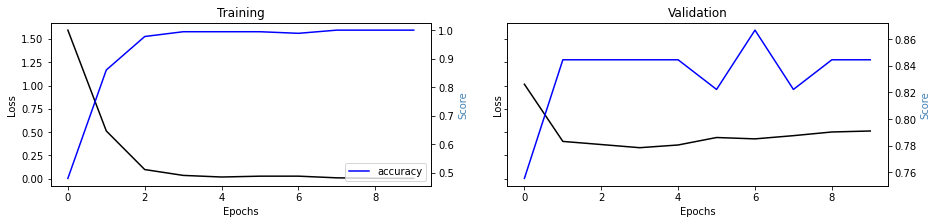

Iteração: 4 Fold: 7 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8826530612244898
Epoch 1/10
23/23 [==============================] - 7s 96ms/step - loss: 1.7465 - accuracy: 0.3554 - val_loss: 1.2578 - val_accuracy: 0.5111
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.5615 - accuracy: 0.8602 - val_loss: 0.6344 - val_accuracy: 0.7556
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1365 - accuracy: 0.9859 - val_loss: 0.7960 - val_accuracy: 0.6889
Epoch 4/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1093 - accuracy: 0.9821 - val_loss: 0.5465 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0374 - accuracy: 0.9859 - val_loss: 0.5648 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0107 - accuracy: 0.9972 - val_loss: 0.6371 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 48ms/step - los

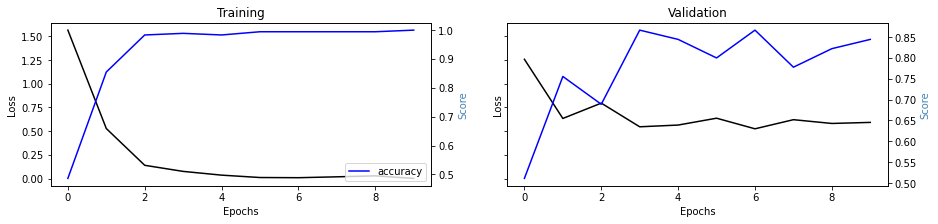

Iteração: 4 Fold: 8 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8839285714285715
Epoch 1/10
23/23 [==============================] - 7s 95ms/step - loss: 1.7759 - accuracy: 0.3747 - val_loss: 1.0344 - val_accuracy: 0.6444
Epoch 2/10
23/23 [==============================] - 1s 47ms/step - loss: 0.5189 - accuracy: 0.8864 - val_loss: 0.9860 - val_accuracy: 0.6889
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1098 - accuracy: 0.9540 - val_loss: 0.4347 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0171 - accuracy: 0.9990 - val_loss: 0.5888 - val_accuracy: 0.7333
Epoch 5/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0258 - accuracy: 0.9930 - val_loss: 0.5510 - val_accuracy: 0.7778
Epoch 6/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0180 - accuracy: 0.9900 - val_loss: 0.5860 - val_accuracy: 0.7556
Epoch 7/10
23/23 [==============================] - 1s 48ms/step - los

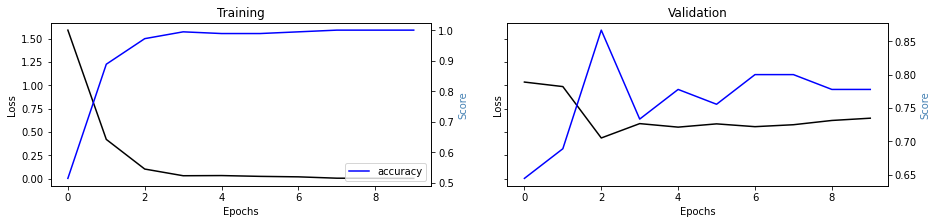

Iteração: 4 Fold: 9 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8789682539682541
Epoch 1/10
23/23 [==============================] - 9s 98ms/step - loss: 1.7007 - accuracy: 0.3531 - val_loss: 1.0738 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 52ms/step - loss: 0.5192 - accuracy: 0.8654 - val_loss: 0.5769 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 50ms/step - loss: 0.1146 - accuracy: 0.9612 - val_loss: 0.6697 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0440 - accuracy: 0.9887 - val_loss: 0.5511 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0265 - accuracy: 0.9888 - val_loss: 0.4611 - val_accuracy: 0.9111
Epoch 6/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.4923 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 48ms/step - los

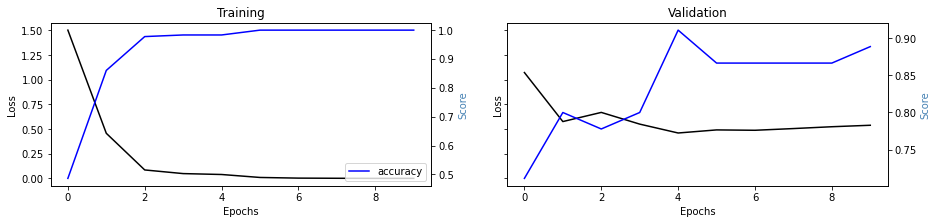

Iteração: 4 Fold: 10 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8821428571428573
Epoch 1/10
23/23 [==============================] - 7s 98ms/step - loss: 1.7432 - accuracy: 0.3413 - val_loss: 1.0676 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.4937 - accuracy: 0.8545 - val_loss: 0.5180 - val_accuracy: 0.8444
Epoch 3/10
23/23 [==============================] - 1s 50ms/step - loss: 0.1495 - accuracy: 0.9475 - val_loss: 0.2942 - val_accuracy: 0.8889
Epoch 4/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0291 - accuracy: 0.9917 - val_loss: 0.2547 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0142 - accuracy: 0.9899 - val_loss: 0.3057 - val_accuracy: 0.9111
Epoch 6/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2955 - val_accuracy: 0.9111
Epoch 7/10
23/23 [==============================] - 1s 47ms/step - lo

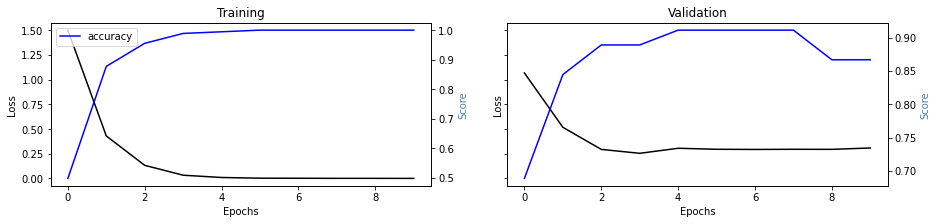

Iteração: 5 Fold: 1 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8571428571428571
Epoch 1/10
23/23 [==============================] - 7s 104ms/step - loss: 1.6795 - accuracy: 0.4310 - val_loss: 0.8650 - val_accuracy: 0.8222
Epoch 2/10
23/23 [==============================] - 1s 51ms/step - loss: 0.3963 - accuracy: 0.9022 - val_loss: 1.0186 - val_accuracy: 0.6667
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 0.1460 - accuracy: 0.9713 - val_loss: 0.5368 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0349 - accuracy: 0.9931 - val_loss: 0.6500 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.6667 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.6649 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 49ms/step - lo

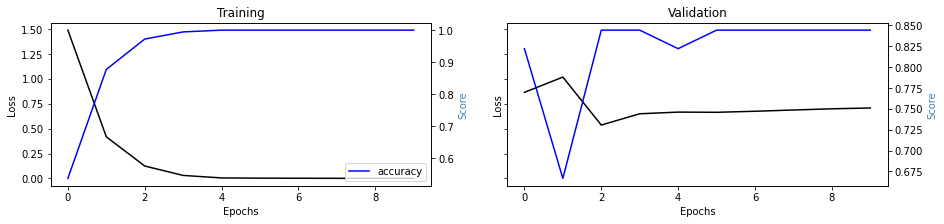

Iteração: 5 Fold: 2 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8571428571428571
Epoch 1/10
23/23 [==============================] - 7s 96ms/step - loss: 1.7242 - accuracy: 0.3624 - val_loss: 1.1418 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 48ms/step - loss: 0.5259 - accuracy: 0.8780 - val_loss: 0.8026 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1151 - accuracy: 0.9655 - val_loss: 0.7653 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0336 - accuracy: 0.9951 - val_loss: 0.9153 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0149 - accuracy: 0.9917 - val_loss: 0.8983 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0209 - accuracy: 0.9917 - val_loss: 0.9612 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 48ms/step - los

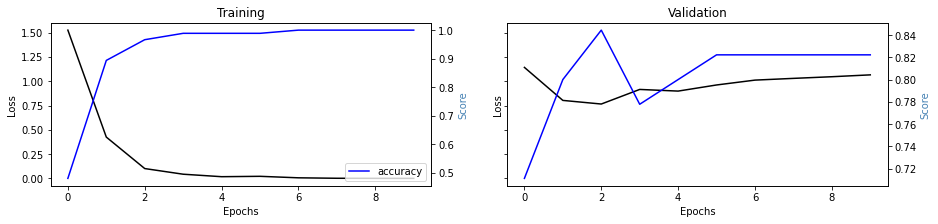

Iteração: 5 Fold: 3 Accuracy: 0.9107142857142857, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 101ms/step - loss: 1.7285 - accuracy: 0.4395 - val_loss: 1.1090 - val_accuracy: 0.6000
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.4396 - accuracy: 0.8729 - val_loss: 0.7389 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0863 - accuracy: 0.9900 - val_loss: 0.7553 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0428 - accuracy: 0.9803 - val_loss: 0.8021 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.8641 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.9895 - val_accuracy: 0.7333
Epoch 7/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0025 - 

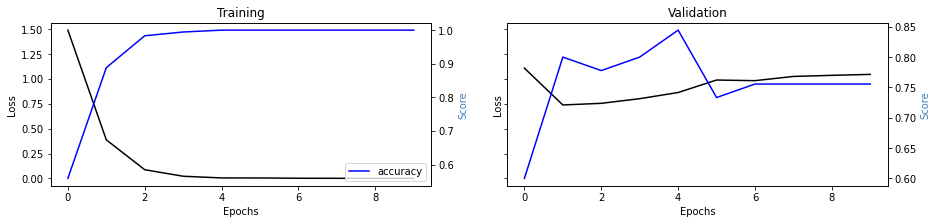

Iteração: 5 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8526785714285714
Epoch 1/10
23/23 [==============================] - 7s 96ms/step - loss: 1.7411 - accuracy: 0.3940 - val_loss: 0.9253 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 48ms/step - loss: 0.5656 - accuracy: 0.8630 - val_loss: 0.6184 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0882 - accuracy: 0.9887 - val_loss: 0.6050 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 44ms/step - loss: 0.0408 - accuracy: 0.9813 - val_loss: 0.4668 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.4739 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 46ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.4855 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 45ms/step - los

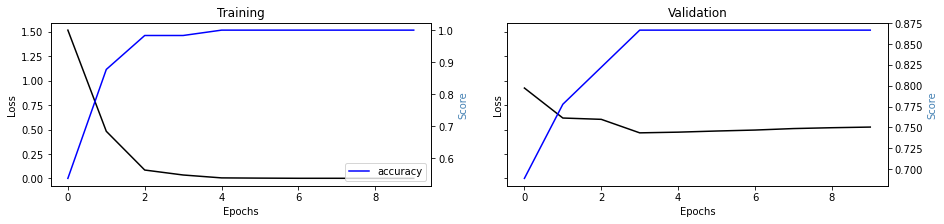

Iteração: 5 Fold: 5 Accuracy: 0.9285714285714286, Mean Accuracy: 0.8678571428571429
Epoch 1/10
23/23 [==============================] - 7s 100ms/step - loss: 1.7382 - accuracy: 0.3917 - val_loss: 0.7864 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 46ms/step - loss: 0.4548 - accuracy: 0.9087 - val_loss: 0.4586 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 46ms/step - loss: 0.1029 - accuracy: 0.9915 - val_loss: 0.3305 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0301 - accuracy: 0.9927 - val_loss: 0.2907 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0294 - accuracy: 0.9969 - val_loss: 0.3528 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0100 - accuracy: 0.9965 - val_loss: 0.3593 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 45ms/step - lo

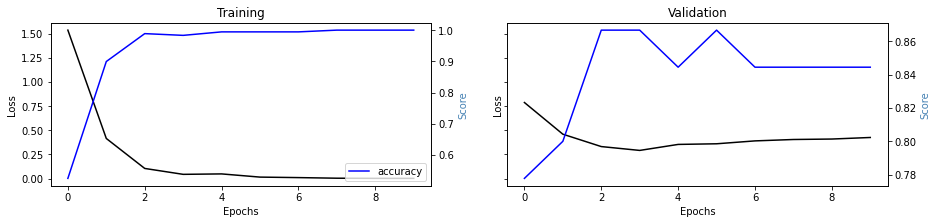

Iteração: 5 Fold: 6 Accuracy: 0.9107142857142857, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 9s 99ms/step - loss: 1.7508 - accuracy: 0.3679 - val_loss: 0.9976 - val_accuracy: 0.7333
Epoch 2/10
23/23 [==============================] - 1s 48ms/step - loss: 0.4889 - accuracy: 0.8873 - val_loss: 0.4089 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 48ms/step - loss: 0.1532 - accuracy: 0.9600 - val_loss: 0.3269 - val_accuracy: 0.8889
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0255 - accuracy: 0.9964 - val_loss: 0.2963 - val_accuracy: 0.9111
Epoch 5/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.2927 - val_accuracy: 0.8889
Epoch 6/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.3122 - val_accuracy: 0.8889
Epoch 7/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0054 - a

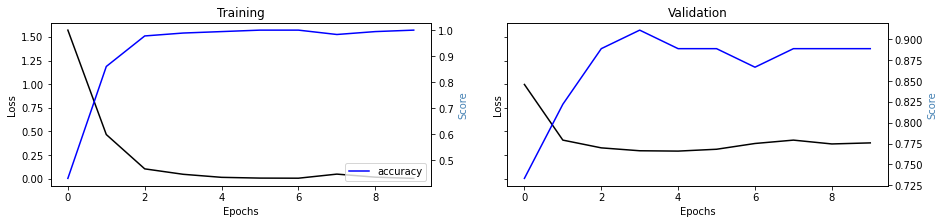

Iteração: 5 Fold: 7 Accuracy: 0.9464285714285714, Mean Accuracy: 0.8852040816326531
Epoch 1/10
23/23 [==============================] - 7s 97ms/step - loss: 1.7649 - accuracy: 0.3244 - val_loss: 1.0651 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 47ms/step - loss: 0.5913 - accuracy: 0.8189 - val_loss: 0.7528 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 0.1682 - accuracy: 0.9477 - val_loss: 0.5199 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0436 - accuracy: 1.0000 - val_loss: 0.6882 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 47ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.7488 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.7892 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 50ms/step - los

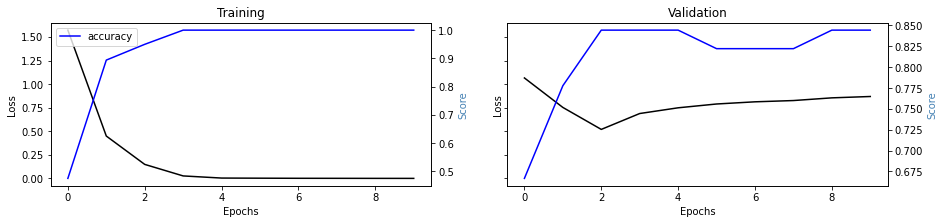

Iteração: 5 Fold: 8 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8861607142857143
Epoch 1/10
23/23 [==============================] - 7s 100ms/step - loss: 1.7284 - accuracy: 0.4066 - val_loss: 0.8629 - val_accuracy: 0.8000
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5478 - accuracy: 0.8958 - val_loss: 0.6702 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0916 - accuracy: 0.9905 - val_loss: 0.6021 - val_accuracy: 0.7556
Epoch 4/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0181 - accuracy: 0.9995 - val_loss: 0.9302 - val_accuracy: 0.7111
Epoch 5/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0347 - accuracy: 0.9945 - val_loss: 0.6373 - val_accuracy: 0.7333
Epoch 6/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0127 - accuracy: 0.9990 - val_loss: 0.5901 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 53ms/step - lo

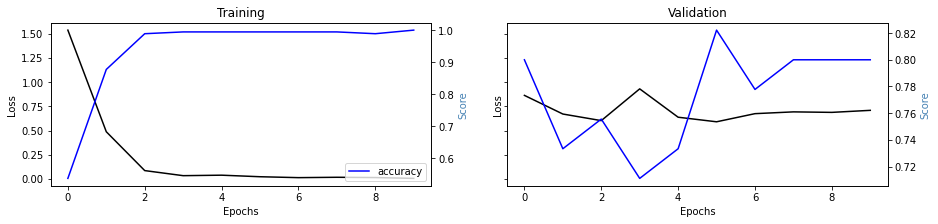

Iteração: 5 Fold: 9 Accuracy: 0.8035714285714286, Mean Accuracy: 0.876984126984127
Epoch 1/10
23/23 [==============================] - 7s 108ms/step - loss: 1.7128 - accuracy: 0.4331 - val_loss: 1.0396 - val_accuracy: 0.6444
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5404 - accuracy: 0.8769 - val_loss: 0.5754 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0682 - accuracy: 0.9956 - val_loss: 0.5704 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.6991 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0109 - accuracy: 0.9976 - val_loss: 0.5938 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0311 - accuracy: 0.9938 - val_loss: 0.6614 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 52ms/step - los

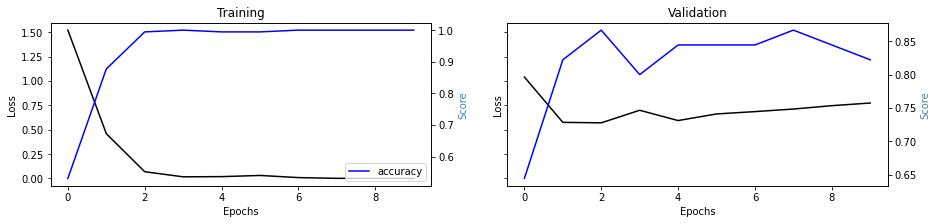

Iteração: 5 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8714285714285716
Epoch 1/10
23/23 [==============================] - 9s 112ms/step - loss: 1.7309 - accuracy: 0.4161 - val_loss: 0.9583 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.6044 - accuracy: 0.8356 - val_loss: 0.6102 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0955 - accuracy: 0.9821 - val_loss: 0.5360 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0304 - accuracy: 0.9900 - val_loss: 0.9053 - val_accuracy: 0.7333
Epoch 5/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0522 - accuracy: 0.9922 - val_loss: 0.5636 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.5950 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 51ms/step - l

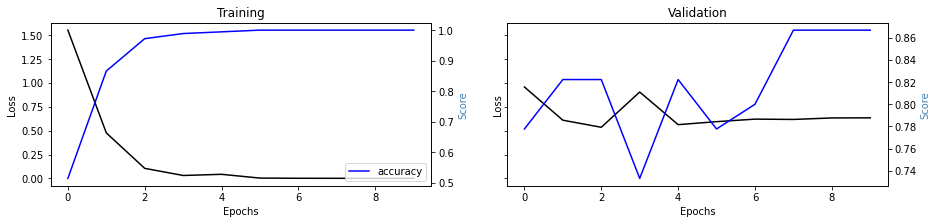

Iteração: 6 Fold: 1 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8928571428571429
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7183 - accuracy: 0.4239 - val_loss: 1.1359 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 52ms/step - loss: 0.5101 - accuracy: 0.9127 - val_loss: 0.5375 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0632 - accuracy: 1.0000 - val_loss: 0.5210 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.4848 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5036 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 49ms/step - lo

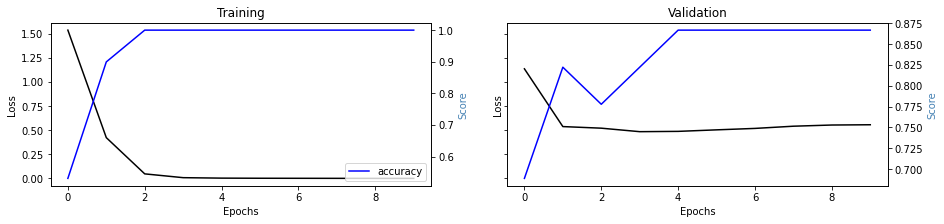

Iteração: 6 Fold: 2 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8571428571428572
Epoch 1/10
23/23 [==============================] - 7s 110ms/step - loss: 1.7077 - accuracy: 0.3932 - val_loss: 0.9839 - val_accuracy: 0.8444
Epoch 2/10
23/23 [==============================] - 1s 60ms/step - loss: 0.5119 - accuracy: 0.8803 - val_loss: 1.0051 - val_accuracy: 0.6000
Epoch 3/10
23/23 [==============================] - 1s 55ms/step - loss: 0.1867 - accuracy: 0.9329 - val_loss: 0.8969 - val_accuracy: 0.7556
Epoch 4/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0441 - accuracy: 0.9929 - val_loss: 0.7932 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0282 - accuracy: 0.9945 - val_loss: 0.8913 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0106 - accuracy: 0.9956 - val_loss: 0.9465 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 53ms/step - lo

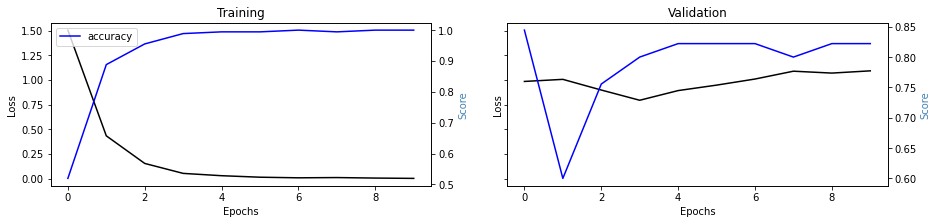

Iteração: 6 Fold: 3 Accuracy: 0.9285714285714286, Mean Accuracy: 0.880952380952381
Epoch 1/10
23/23 [==============================] - 7s 105ms/step - loss: 1.7955 - accuracy: 0.3927 - val_loss: 1.2700 - val_accuracy: 0.5333
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5161 - accuracy: 0.8872 - val_loss: 0.9792 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 55ms/step - loss: 0.1182 - accuracy: 0.9727 - val_loss: 0.9896 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0890 - accuracy: 0.9539 - val_loss: 0.9064 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 1.0138 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.0697 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - los

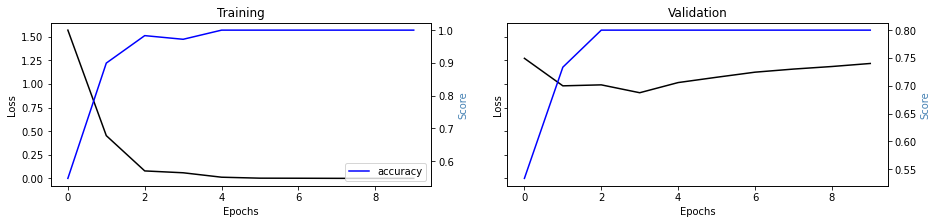

Iteração: 6 Fold: 4 Accuracy: 0.8035714285714286, Mean Accuracy: 0.861607142857143
Epoch 1/10
23/23 [==============================] - 7s 101ms/step - loss: 1.7364 - accuracy: 0.3336 - val_loss: 1.0901 - val_accuracy: 0.6222
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5595 - accuracy: 0.8718 - val_loss: 0.6176 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 48ms/step - loss: 0.1165 - accuracy: 0.9789 - val_loss: 0.5226 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0283 - accuracy: 0.9961 - val_loss: 0.6079 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 48ms/step - loss: 0.0960 - accuracy: 0.9812 - val_loss: 0.5454 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.5823 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 50ms/step - los

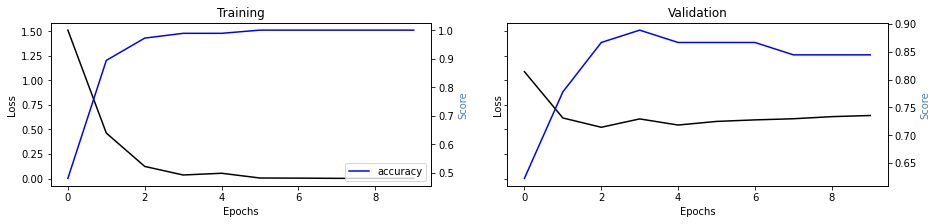

Iteração: 6 Fold: 5 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8714285714285716
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7512 - accuracy: 0.3721 - val_loss: 0.9985 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 47ms/step - loss: 0.5706 - accuracy: 0.8890 - val_loss: 0.5756 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 0.1799 - accuracy: 0.9648 - val_loss: 0.3414 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0363 - accuracy: 0.9985 - val_loss: 0.3970 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.4211 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.4125 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 50ms/step - lo

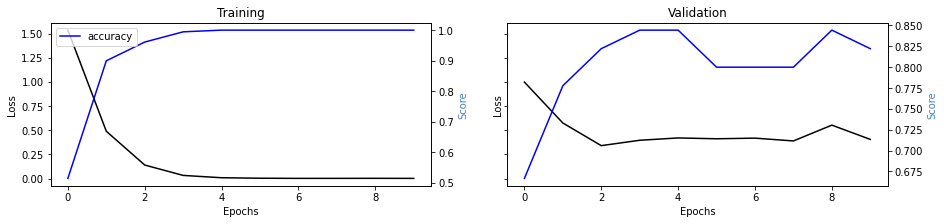

Iteração: 6 Fold: 6 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8779761904761906
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7785 - accuracy: 0.3093 - val_loss: 0.9272 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 51ms/step - loss: 0.5902 - accuracy: 0.8694 - val_loss: 0.3446 - val_accuracy: 0.9111
Epoch 3/10
23/23 [==============================] - 1s 53ms/step - loss: 0.1274 - accuracy: 0.9834 - val_loss: 0.3908 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0290 - accuracy: 0.9866 - val_loss: 0.4381 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0418 - accuracy: 0.9907 - val_loss: 0.4253 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.4701 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - lo

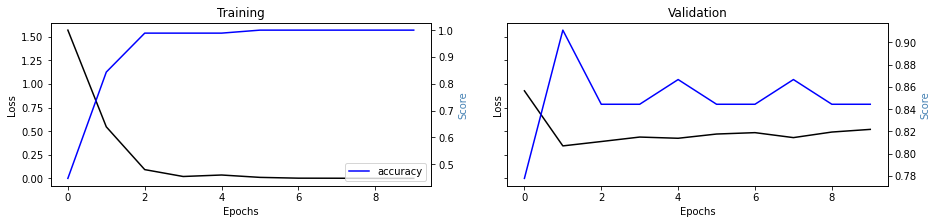

Iteração: 6 Fold: 7 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8826530612244898
Epoch 1/10
23/23 [==============================] - 9s 106ms/step - loss: 1.7707 - accuracy: 0.3150 - val_loss: 0.9699 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 56ms/step - loss: 0.5535 - accuracy: 0.8538 - val_loss: 0.7791 - val_accuracy: 0.6889
Epoch 3/10
23/23 [==============================] - 1s 57ms/step - loss: 0.1238 - accuracy: 0.9667 - val_loss: 0.7009 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 60ms/step - loss: 0.0243 - accuracy: 0.9995 - val_loss: 0.9180 - val_accuracy: 0.7333
Epoch 5/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0560 - accuracy: 0.9754 - val_loss: 0.7195 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.7008 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 58ms/step - lo

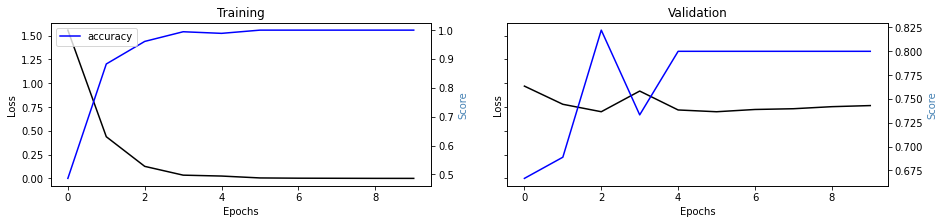

Iteração: 6 Fold: 8 Accuracy: 0.8214285714285714, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7366 - accuracy: 0.4093 - val_loss: 1.0311 - val_accuracy: 0.6222
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.4391 - accuracy: 0.8755 - val_loss: 0.6640 - val_accuracy: 0.6444
Epoch 3/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0923 - accuracy: 0.9839 - val_loss: 0.6198 - val_accuracy: 0.7556
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0350 - accuracy: 0.9990 - val_loss: 0.6701 - val_accuracy: 0.7333
Epoch 5/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0156 - accuracy: 0.9891 - val_loss: 0.7398 - val_accuracy: 0.7333
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.5925 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0053 - 

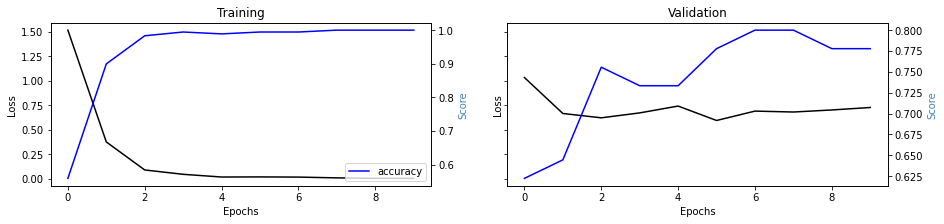

Iteração: 6 Fold: 9 Accuracy: 0.875, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 106ms/step - loss: 1.7153 - accuracy: 0.4127 - val_loss: 1.0787 - val_accuracy: 0.6222
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5869 - accuracy: 0.8169 - val_loss: 0.8350 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 48ms/step - loss: 0.1362 - accuracy: 0.9701 - val_loss: 0.7834 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0735 - accuracy: 0.9916 - val_loss: 0.6127 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0686 - accuracy: 0.9846 - val_loss: 0.5516 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.5975 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0065 - accuracy: 1.0

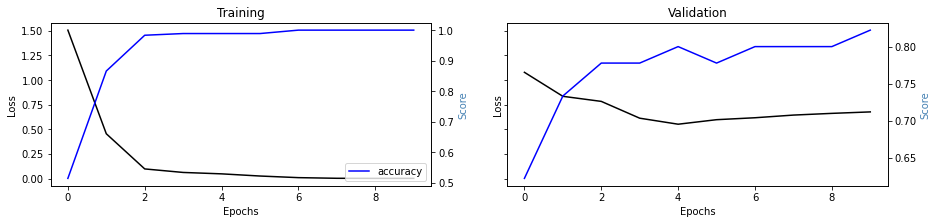

Iteração: 6 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8696428571428572
Epoch 1/10
23/23 [==============================] - 7s 100ms/step - loss: 1.7243 - accuracy: 0.3382 - val_loss: 1.0251 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 50ms/step - loss: 0.4923 - accuracy: 0.9075 - val_loss: 0.4046 - val_accuracy: 0.8444
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 0.1018 - accuracy: 0.9703 - val_loss: 0.3992 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0434 - accuracy: 0.9754 - val_loss: 0.4843 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 49ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5511 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.6034 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - l

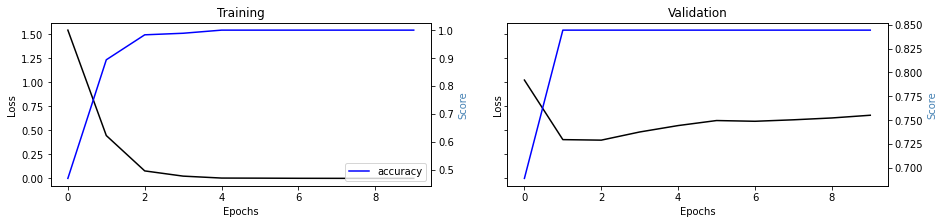

Iteração: 7 Fold: 1 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9285714285714286
Epoch 1/10
23/23 [==============================] - 9s 110ms/step - loss: 1.7743 - accuracy: 0.4169 - val_loss: 0.9180 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.5256 - accuracy: 0.8891 - val_loss: 0.6537 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0996 - accuracy: 0.9938 - val_loss: 0.5590 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0984 - accuracy: 0.9658 - val_loss: 0.5391 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 50ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.5518 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.5440 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - lo

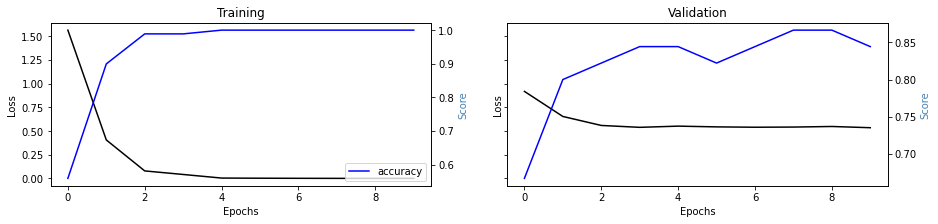

Iteração: 7 Fold: 2 Accuracy: 0.875, Mean Accuracy: 0.9017857142857143
Epoch 1/10
23/23 [==============================] - 7s 106ms/step - loss: 1.7510 - accuracy: 0.3525 - val_loss: 1.0407 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 61ms/step - loss: 0.5393 - accuracy: 0.8954 - val_loss: 0.8261 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0835 - accuracy: 0.9916 - val_loss: 0.8652 - val_accuracy: 0.6889
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 0.1705 - accuracy: 0.9478 - val_loss: 0.7634 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0243 - accuracy: 0.9969 - val_loss: 0.8722 - val_accuracy: 0.7778
Epoch 6/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0321 - accuracy: 0.9803 - val_loss: 0.8688 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0035 - 

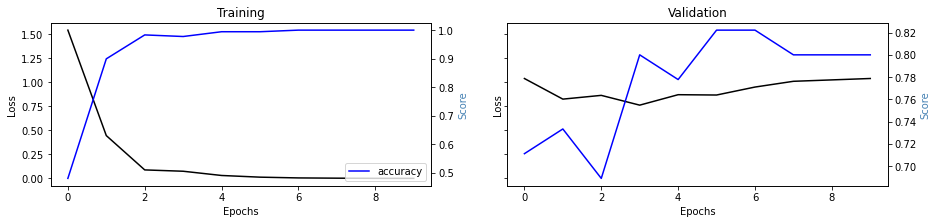

Iteração: 7 Fold: 3 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8869047619047619
Epoch 1/10
23/23 [==============================] - 7s 105ms/step - loss: 1.7246 - accuracy: 0.4332 - val_loss: 1.2446 - val_accuracy: 0.5778
Epoch 2/10
23/23 [==============================] - 1s 59ms/step - loss: 0.4994 - accuracy: 0.8943 - val_loss: 1.0365 - val_accuracy: 0.6889
Epoch 3/10
23/23 [==============================] - 1s 61ms/step - loss: 0.1267 - accuracy: 0.9711 - val_loss: 0.6981 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.9838 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.9438 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.9539 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 56ms/step - lo

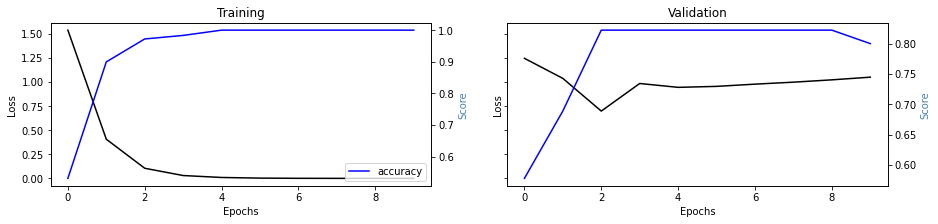

Iteração: 7 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8616071428571428
Epoch 1/10
23/23 [==============================] - 7s 100ms/step - loss: 1.7618 - accuracy: 0.3337 - val_loss: 0.9172 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 58ms/step - loss: 0.5106 - accuracy: 0.8845 - val_loss: 0.5465 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.2112 - accuracy: 0.9323 - val_loss: 0.3814 - val_accuracy: 0.8889
Epoch 4/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0287 - accuracy: 0.9960 - val_loss: 0.3912 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.4366 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.4444 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 56ms/step - lo

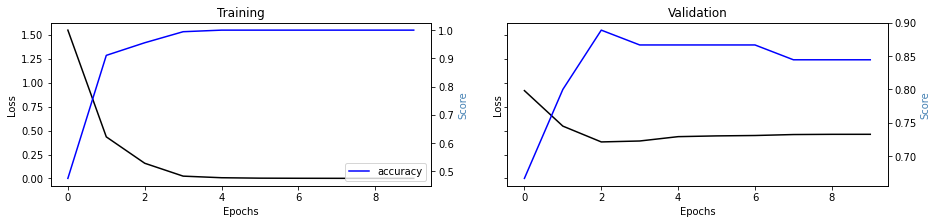

Iteração: 7 Fold: 5 Accuracy: 0.9285714285714286, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 106ms/step - loss: 1.7758 - accuracy: 0.3797 - val_loss: 1.0289 - val_accuracy: 0.6222
Epoch 2/10
23/23 [==============================] - 1s 55ms/step - loss: 0.5958 - accuracy: 0.8876 - val_loss: 0.5717 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 0.1295 - accuracy: 0.9776 - val_loss: 0.3441 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0274 - accuracy: 0.9970 - val_loss: 0.5566 - val_accuracy: 0.7556
Epoch 5/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0616 - accuracy: 0.9887 - val_loss: 0.3960 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.3714 - val_accuracy: 0.8889
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0099 - 

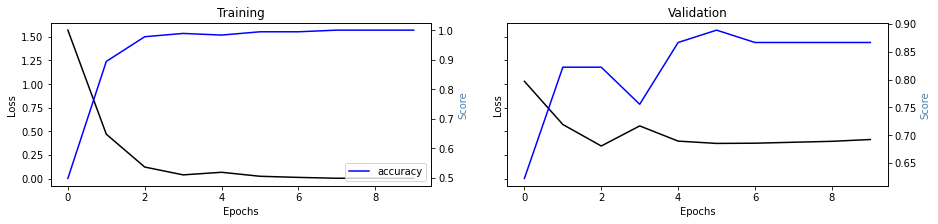

Iteração: 7 Fold: 6 Accuracy: 0.9285714285714286, Mean Accuracy: 0.8839285714285715
Epoch 1/10
23/23 [==============================] - 7s 100ms/step - loss: 1.7478 - accuracy: 0.3846 - val_loss: 1.0879 - val_accuracy: 0.6000
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5922 - accuracy: 0.8349 - val_loss: 0.9393 - val_accuracy: 0.6444
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.2439 - accuracy: 0.9598 - val_loss: 0.3095 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0337 - accuracy: 0.9965 - val_loss: 0.5009 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0448 - accuracy: 0.9941 - val_loss: 0.3187 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0116 - accuracy: 0.9982 - val_loss: 0.3251 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - lo

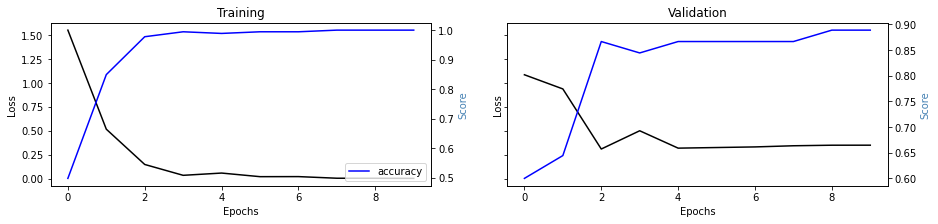

Iteração: 7 Fold: 7 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8877551020408163
Epoch 1/10
23/23 [==============================] - 7s 103ms/step - loss: 1.7299 - accuracy: 0.3933 - val_loss: 1.5370 - val_accuracy: 0.4000
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.6313 - accuracy: 0.8644 - val_loss: 1.0385 - val_accuracy: 0.6667
Epoch 3/10
23/23 [==============================] - 1s 55ms/step - loss: 0.1534 - accuracy: 0.9360 - val_loss: 0.5685 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.6555 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 60ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.7179 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.7195 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - lo

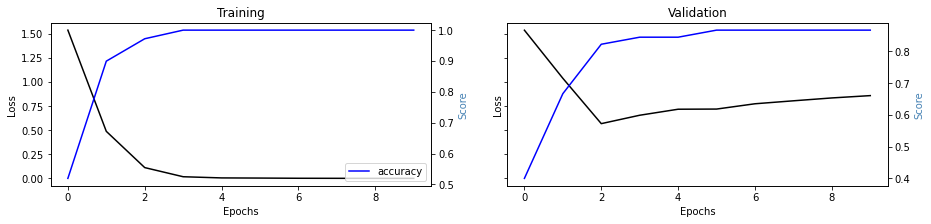

Iteração: 7 Fold: 8 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8839285714285714
Epoch 1/10
23/23 [==============================] - 9s 110ms/step - loss: 1.7100 - accuracy: 0.4296 - val_loss: 1.0711 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5845 - accuracy: 0.9051 - val_loss: 0.6847 - val_accuracy: 0.6889
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.1137 - accuracy: 0.9614 - val_loss: 0.5925 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0822 - accuracy: 0.9867 - val_loss: 0.6017 - val_accuracy: 0.7556
Epoch 5/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0489 - accuracy: 0.9837 - val_loss: 0.5271 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0166 - accuracy: 0.9917 - val_loss: 0.5181 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 58ms/step - lo

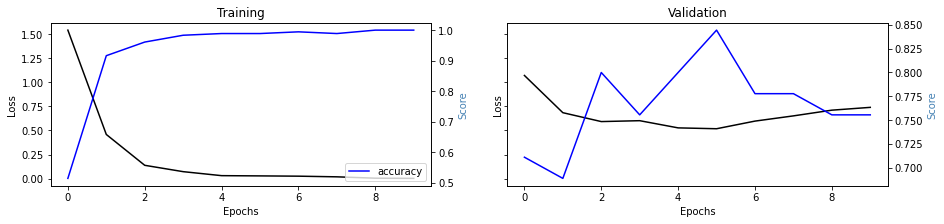

Iteração: 7 Fold: 9 Accuracy: 0.8214285714285714, Mean Accuracy: 0.876984126984127
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7330 - accuracy: 0.3749 - val_loss: 1.1835 - val_accuracy: 0.5778
Epoch 2/10
23/23 [==============================] - 1s 52ms/step - loss: 0.4666 - accuracy: 0.8897 - val_loss: 0.6444 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0928 - accuracy: 0.9846 - val_loss: 0.7948 - val_accuracy: 0.7333
Epoch 4/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0325 - accuracy: 0.9907 - val_loss: 0.8491 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0289 - accuracy: 0.9776 - val_loss: 0.9076 - val_accuracy: 0.7778
Epoch 6/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0255 - accuracy: 0.9904 - val_loss: 0.8328 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 53ms/step - los

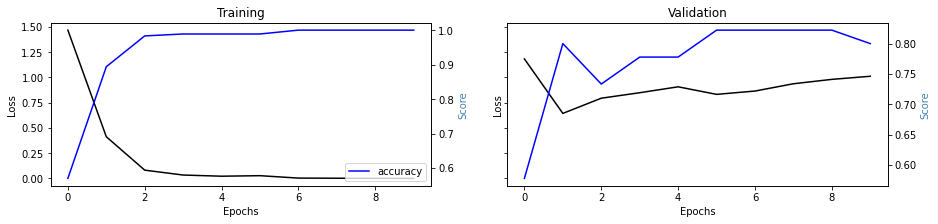

Iteração: 7 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8714285714285713
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7069 - accuracy: 0.3952 - val_loss: 1.1443 - val_accuracy: 0.5556
Epoch 2/10
23/23 [==============================] - 1s 59ms/step - loss: 0.4864 - accuracy: 0.9120 - val_loss: 0.5593 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 53ms/step - loss: 0.1099 - accuracy: 0.9768 - val_loss: 0.7963 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0385 - accuracy: 0.9948 - val_loss: 0.7050 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.7981 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.8179 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 53ms/step - l

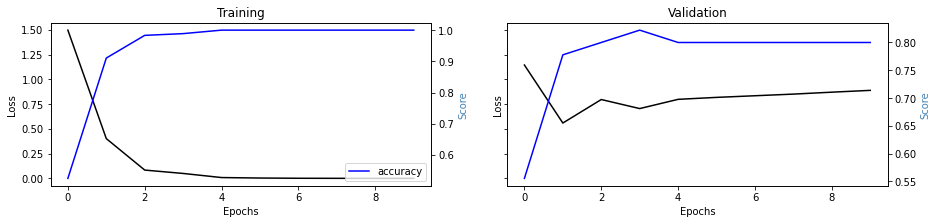

Iteração: 8 Fold: 1 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9285714285714286
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7478 - accuracy: 0.3841 - val_loss: 1.0158 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 51ms/step - loss: 0.6049 - accuracy: 0.8534 - val_loss: 0.6987 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 49ms/step - loss: 0.1015 - accuracy: 0.9596 - val_loss: 0.3563 - val_accuracy: 0.8889
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.3676 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.4101 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4374 - val_accuracy: 0.8889
Epoch 7/10
23/23 [==============================] - 1s 53ms/step - lo

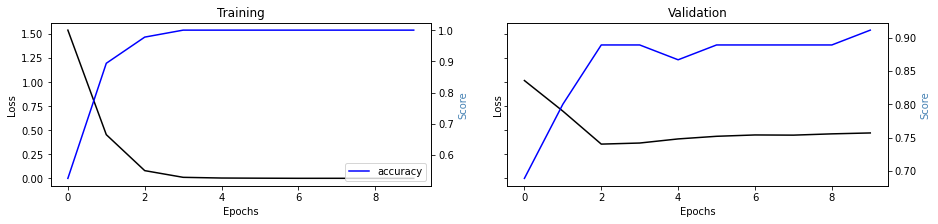

Iteração: 8 Fold: 2 Accuracy: 0.875, Mean Accuracy: 0.9017857142857143
Epoch 1/10
23/23 [==============================] - 10s 105ms/step - loss: 1.7568 - accuracy: 0.4082 - val_loss: 1.0181 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.5128 - accuracy: 0.9111 - val_loss: 0.7244 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0925 - accuracy: 0.9780 - val_loss: 0.7091 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0335 - accuracy: 0.9913 - val_loss: 0.8693 - val_accuracy: 0.7111
Epoch 5/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0128 - accuracy: 0.9929 - val_loss: 0.9302 - val_accuracy: 0.7556
Epoch 6/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0126 - accuracy: 0.9921 - val_loss: 0.9933 - val_accuracy: 0.7111
Epoch 7/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0140 -

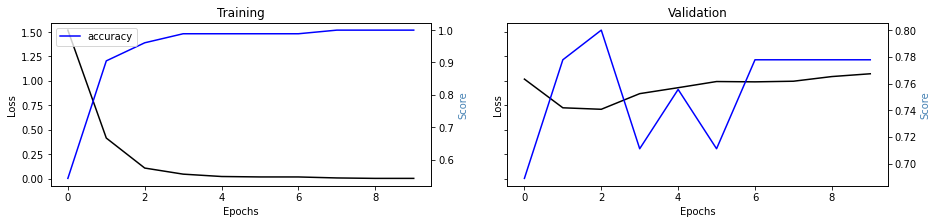

Iteração: 8 Fold: 3 Accuracy: 0.9285714285714286, Mean Accuracy: 0.9107142857142857
Epoch 1/10
23/23 [==============================] - 7s 103ms/step - loss: 1.7441 - accuracy: 0.3798 - val_loss: 1.0727 - val_accuracy: 0.6000
Epoch 2/10
23/23 [==============================] - 1s 59ms/step - loss: 0.4195 - accuracy: 0.9025 - val_loss: 0.8170 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 60ms/step - loss: 0.1263 - accuracy: 0.9790 - val_loss: 0.6858 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0404 - accuracy: 0.9933 - val_loss: 1.0463 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0470 - accuracy: 0.9774 - val_loss: 0.9935 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 1.0229 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - lo

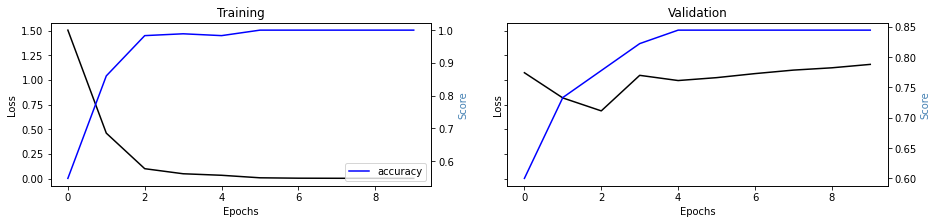

Iteração: 8 Fold: 4 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8839285714285714
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7376 - accuracy: 0.4496 - val_loss: 0.8951 - val_accuracy: 0.8222
Epoch 2/10
23/23 [==============================] - 1s 56ms/step - loss: 0.4530 - accuracy: 0.9073 - val_loss: 0.9903 - val_accuracy: 0.6667
Epoch 3/10
23/23 [==============================] - 1s 57ms/step - loss: 0.2076 - accuracy: 0.9464 - val_loss: 0.5135 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0435 - accuracy: 0.9855 - val_loss: 0.5378 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.5728 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.5996 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - lo

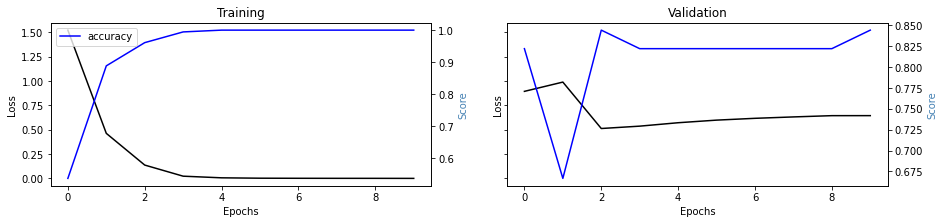

Iteração: 8 Fold: 5 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8785714285714284
Epoch 1/10
23/23 [==============================] - 7s 102ms/step - loss: 1.8278 - accuracy: 0.3244 - val_loss: 1.1112 - val_accuracy: 0.5778
Epoch 2/10
23/23 [==============================] - 1s 55ms/step - loss: 0.5662 - accuracy: 0.8317 - val_loss: 0.5805 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 53ms/step - loss: 0.1460 - accuracy: 0.9774 - val_loss: 0.3329 - val_accuracy: 0.8889
Epoch 4/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0358 - accuracy: 0.9932 - val_loss: 0.2415 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.2429 - val_accuracy: 0.8889
Epoch 6/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2562 - val_accuracy: 0.9111
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - lo

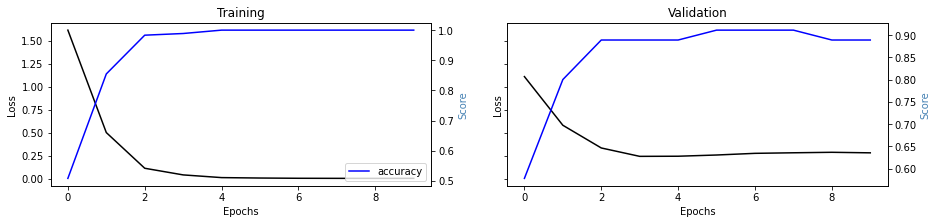

Iteração: 8 Fold: 6 Accuracy: 0.9464285714285714, Mean Accuracy: 0.8898809523809522
Epoch 1/10
23/23 [==============================] - 8s 107ms/step - loss: 1.7301 - accuracy: 0.3675 - val_loss: 1.0626 - val_accuracy: 0.5556
Epoch 2/10
23/23 [==============================] - 1s 57ms/step - loss: 0.5969 - accuracy: 0.8972 - val_loss: 0.7701 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 54ms/step - loss: 0.2550 - accuracy: 0.9482 - val_loss: 0.3725 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 60ms/step - loss: 0.0534 - accuracy: 0.9799 - val_loss: 0.3820 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0112 - accuracy: 0.9988 - val_loss: 0.2989 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.4020 - val_accuracy: 0.8889
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - lo

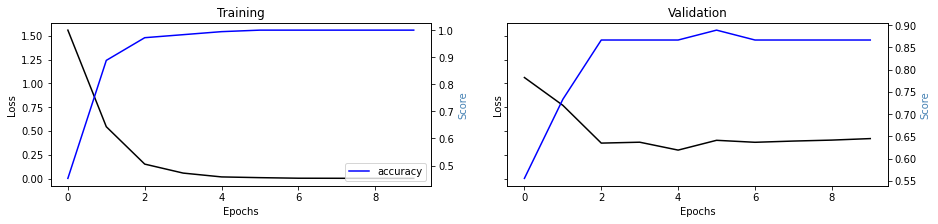

Iteração: 8 Fold: 7 Accuracy: 0.9285714285714286, Mean Accuracy: 0.895408163265306
Epoch 1/10
23/23 [==============================] - 7s 105ms/step - loss: 1.7577 - accuracy: 0.3936 - val_loss: 0.8306 - val_accuracy: 0.8000
Epoch 2/10
23/23 [==============================] - 1s 58ms/step - loss: 0.4656 - accuracy: 0.8960 - val_loss: 0.7779 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0809 - accuracy: 0.9873 - val_loss: 0.9402 - val_accuracy: 0.7333
Epoch 4/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0471 - accuracy: 0.9932 - val_loss: 0.8460 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0364 - accuracy: 0.9855 - val_loss: 0.6524 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0192 - accuracy: 0.9905 - val_loss: 0.7033 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 55ms/step - los

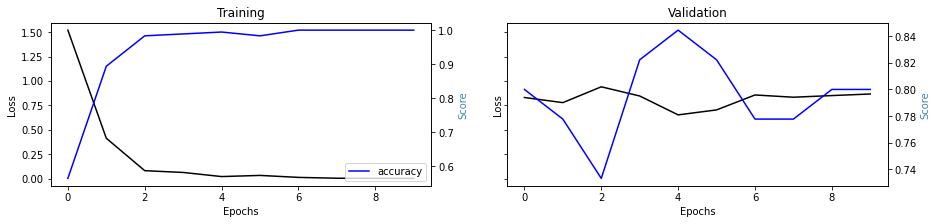

Iteração: 8 Fold: 8 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8883928571428571
Epoch 1/10
23/23 [==============================] - 7s 105ms/step - loss: 1.7542 - accuracy: 0.3594 - val_loss: 1.1690 - val_accuracy: 0.5778
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.5731 - accuracy: 0.8523 - val_loss: 0.8085 - val_accuracy: 0.7556
Epoch 3/10
23/23 [==============================] - 1s 53ms/step - loss: 0.1096 - accuracy: 0.9785 - val_loss: 0.7274 - val_accuracy: 0.7333
Epoch 4/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0277 - accuracy: 0.9993 - val_loss: 0.6110 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0170 - accuracy: 0.9956 - val_loss: 0.8050 - val_accuracy: 0.8000
Epoch 6/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0081 - accuracy: 0.9957 - val_loss: 0.8181 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 58ms/step - lo

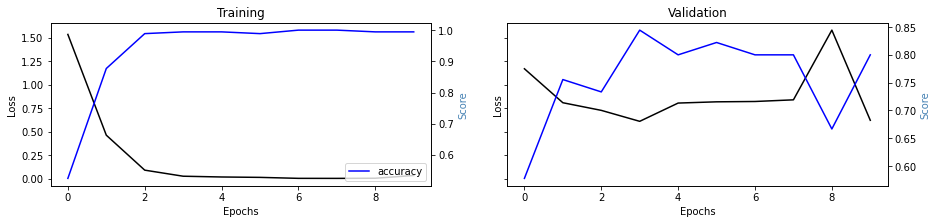

Iteração: 8 Fold: 9 Accuracy: 0.875, Mean Accuracy: 0.8869047619047619
Epoch 1/10
23/23 [==============================] - 9s 109ms/step - loss: 1.7393 - accuracy: 0.3664 - val_loss: 1.1600 - val_accuracy: 0.6000
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.5357 - accuracy: 0.8750 - val_loss: 0.7076 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 57ms/step - loss: 0.1223 - accuracy: 0.9723 - val_loss: 0.6860 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0457 - accuracy: 0.9881 - val_loss: 0.7639 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 62ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.8038 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.8416 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0021 - 

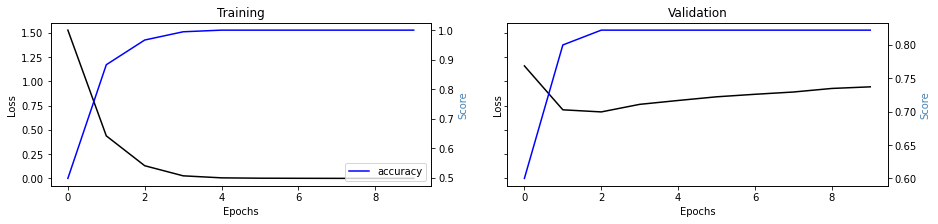

Iteração: 8 Fold: 10 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8821428571428571
Epoch 1/10
23/23 [==============================] - 8s 109ms/step - loss: 1.8000 - accuracy: 0.2862 - val_loss: 0.9134 - val_accuracy: 0.8000
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.5461 - accuracy: 0.8565 - val_loss: 0.5633 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 52ms/step - loss: 0.1357 - accuracy: 0.9788 - val_loss: 0.5381 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0302 - accuracy: 0.9843 - val_loss: 0.5919 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0123 - accuracy: 0.9978 - val_loss: 0.5461 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.5378 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 55ms/step - l

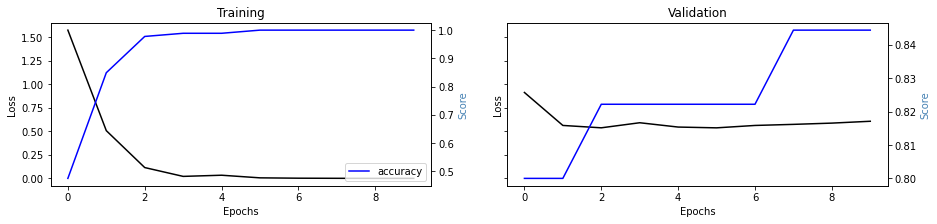

Iteração: 9 Fold: 1 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8928571428571429
Epoch 1/10
23/23 [==============================] - 7s 103ms/step - loss: 1.7699 - accuracy: 0.3225 - val_loss: 1.0509 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 56ms/step - loss: 0.5418 - accuracy: 0.9021 - val_loss: 0.6429 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.1080 - accuracy: 0.9749 - val_loss: 0.4263 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 0.0359 - accuracy: 0.9855 - val_loss: 0.3863 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 53ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.3995 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.5711 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 52ms/step - lo

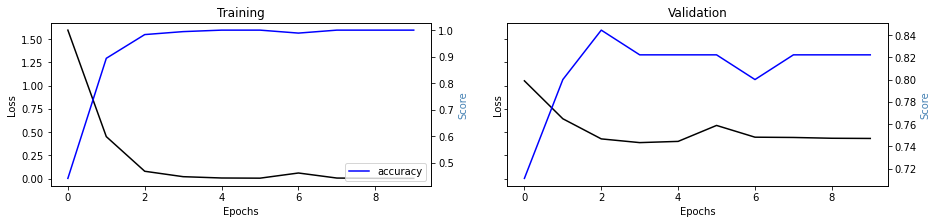

Iteração: 9 Fold: 2 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8928571428571429
Epoch 1/10
23/23 [==============================] - 7s 106ms/step - loss: 1.7511 - accuracy: 0.3609 - val_loss: 1.1951 - val_accuracy: 0.5778
Epoch 2/10
23/23 [==============================] - 1s 57ms/step - loss: 0.4643 - accuracy: 0.9135 - val_loss: 0.7815 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.1041 - accuracy: 0.9677 - val_loss: 1.0257 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0470 - accuracy: 0.9843 - val_loss: 1.0238 - val_accuracy: 0.7778
Epoch 5/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0172 - accuracy: 0.9905 - val_loss: 1.1956 - val_accuracy: 0.7778
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.2820 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - lo

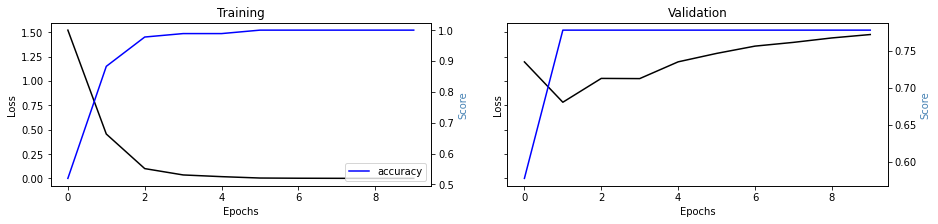

Iteração: 9 Fold: 3 Accuracy: 0.875, Mean Accuracy: 0.8869047619047619
Epoch 1/10
23/23 [==============================] - 9s 106ms/step - loss: 1.7371 - accuracy: 0.3081 - val_loss: 1.2577 - val_accuracy: 0.5778
Epoch 2/10
23/23 [==============================] - 1s 57ms/step - loss: 0.5144 - accuracy: 0.9068 - val_loss: 0.8781 - val_accuracy: 0.6444
Epoch 3/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0814 - accuracy: 0.9958 - val_loss: 0.8717 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0585 - accuracy: 0.9709 - val_loss: 1.1073 - val_accuracy: 0.7556
Epoch 5/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.1747 - val_accuracy: 0.7556
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.2238 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 60ms/step - loss: 0.0019 - 

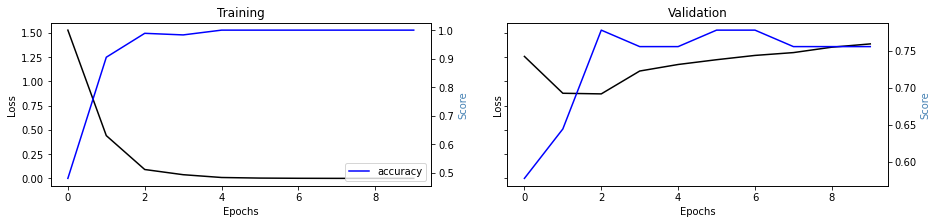

Iteração: 9 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8616071428571428
Epoch 1/10
23/23 [==============================] - 7s 105ms/step - loss: 1.7297 - accuracy: 0.3671 - val_loss: 0.8360 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.4755 - accuracy: 0.8850 - val_loss: 1.0761 - val_accuracy: 0.6667
Epoch 3/10
23/23 [==============================] - 1s 57ms/step - loss: 0.2793 - accuracy: 0.9483 - val_loss: 0.5148 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0328 - accuracy: 0.9944 - val_loss: 0.6180 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.6136 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.6196 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 56ms/step - lo

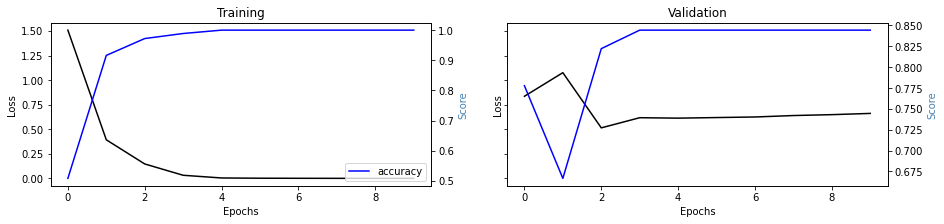

Iteração: 9 Fold: 5 Accuracy: 0.875, Mean Accuracy: 0.8642857142857142
Epoch 1/10
23/23 [==============================] - 7s 109ms/step - loss: 1.7460 - accuracy: 0.3642 - val_loss: 0.8939 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 58ms/step - loss: 0.5401 - accuracy: 0.8683 - val_loss: 0.4242 - val_accuracy: 0.8000
Epoch 3/10
23/23 [==============================] - 1s 53ms/step - loss: 0.1092 - accuracy: 0.9880 - val_loss: 0.5646 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 60ms/step - loss: 0.0777 - accuracy: 0.9651 - val_loss: 0.4588 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.4299 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.4817 - val_accuracy: 0.8000
Epoch 7/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0101 - 

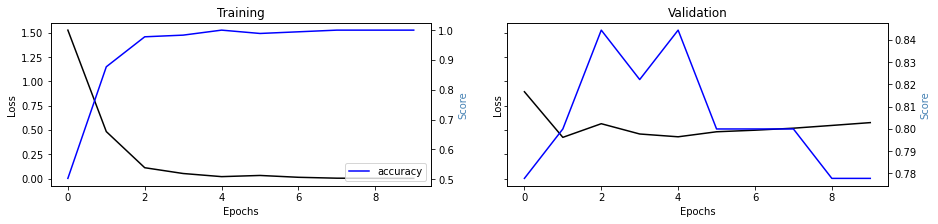

Iteração: 9 Fold: 6 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8720238095238094
Epoch 1/10
23/23 [==============================] - 7s 111ms/step - loss: 1.7777 - accuracy: 0.3302 - val_loss: 1.0010 - val_accuracy: 0.6000
Epoch 2/10
23/23 [==============================] - 1s 57ms/step - loss: 0.5906 - accuracy: 0.8391 - val_loss: 0.4060 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 61ms/step - loss: 0.1608 - accuracy: 0.9616 - val_loss: 0.2824 - val_accuracy: 0.9111
Epoch 4/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0430 - accuracy: 0.9724 - val_loss: 0.2454 - val_accuracy: 0.9111
Epoch 5/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0104 - accuracy: 0.9988 - val_loss: 0.3286 - val_accuracy: 0.9111
Epoch 6/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.3030 - val_accuracy: 0.9111
Epoch 7/10
23/23 [==============================] - 1s 61ms/step - lo

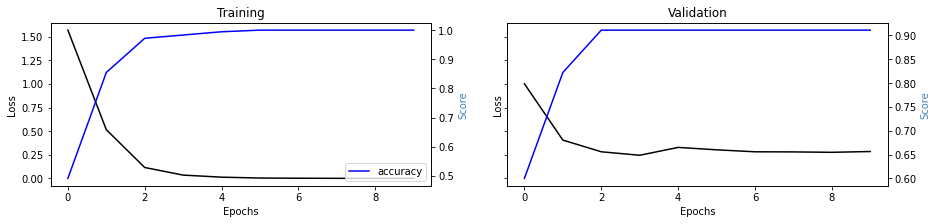

Iteração: 9 Fold: 7 Accuracy: 0.9464285714285714, Mean Accuracy: 0.8826530612244897
Epoch 1/10
23/23 [==============================] - 7s 109ms/step - loss: 1.7471 - accuracy: 0.3596 - val_loss: 1.3150 - val_accuracy: 0.4667
Epoch 2/10
23/23 [==============================] - 1s 57ms/step - loss: 0.6194 - accuracy: 0.7904 - val_loss: 0.6032 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 57ms/step - loss: 0.1237 - accuracy: 0.9875 - val_loss: 0.6524 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0414 - accuracy: 0.9763 - val_loss: 0.7346 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.7357 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.7594 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 55ms/step - lo

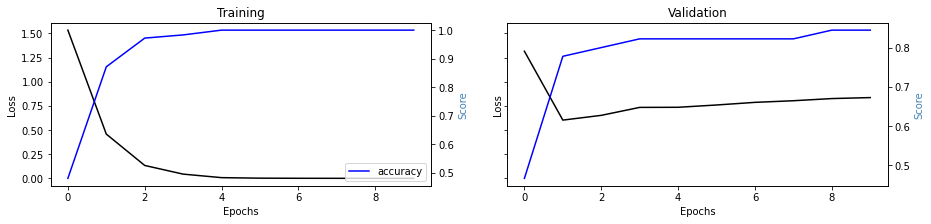

Iteração: 9 Fold: 8 Accuracy: 0.875, Mean Accuracy: 0.8816964285714285
Epoch 1/10
23/23 [==============================] - 7s 109ms/step - loss: 1.7634 - accuracy: 0.3236 - val_loss: 1.0633 - val_accuracy: 0.6444
Epoch 2/10
23/23 [==============================] - 1s 56ms/step - loss: 0.5697 - accuracy: 0.8657 - val_loss: 0.7142 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0960 - accuracy: 0.9810 - val_loss: 0.6756 - val_accuracy: 0.7556
Epoch 4/10
23/23 [==============================] - 1s 58ms/step - loss: 0.1230 - accuracy: 0.9613 - val_loss: 0.5306 - val_accuracy: 0.7556
Epoch 5/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0352 - accuracy: 0.9832 - val_loss: 0.5834 - val_accuracy: 0.7556
Epoch 6/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0089 - accuracy: 0.9946 - val_loss: 0.5609 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0377 - 

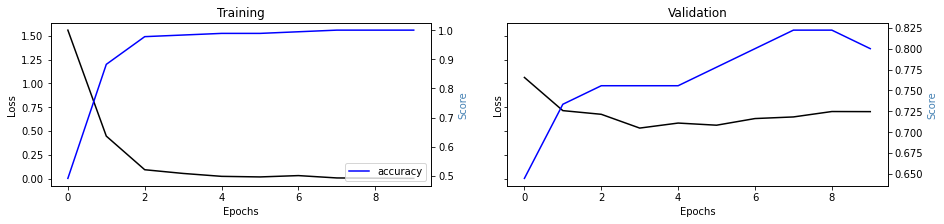

Iteração: 9 Fold: 9 Accuracy: 0.8392857142857143, Mean Accuracy: 0.876984126984127
Epoch 1/10
23/23 [==============================] - 7s 109ms/step - loss: 1.7526 - accuracy: 0.3764 - val_loss: 0.9866 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 59ms/step - loss: 0.5198 - accuracy: 0.8594 - val_loss: 0.7160 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0789 - accuracy: 0.9879 - val_loss: 0.5681 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0209 - accuracy: 0.9972 - val_loss: 0.5356 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.5582 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.5804 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - los

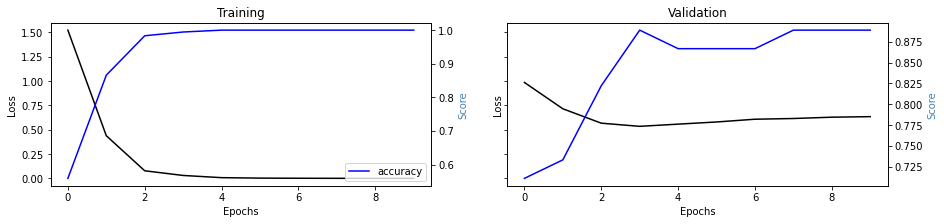

Iteração: 9 Fold: 10 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8732142857142856
Epoch 1/10
23/23 [==============================] - 9s 107ms/step - loss: 1.7934 - accuracy: 0.3328 - val_loss: 1.0809 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 56ms/step - loss: 0.5577 - accuracy: 0.8605 - val_loss: 0.6525 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.1401 - accuracy: 0.9802 - val_loss: 0.5625 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0401 - accuracy: 0.9854 - val_loss: 0.4964 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 52ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.5349 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5673 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 59ms/step - l

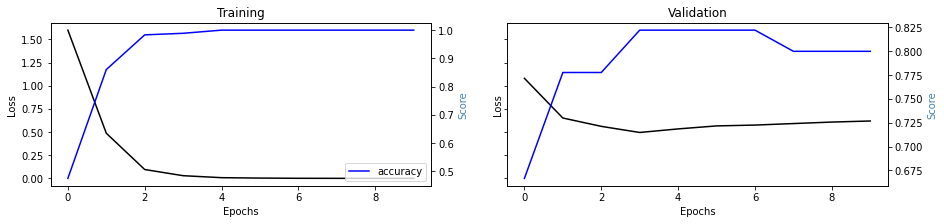

Iteração: 10 Fold: 1 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8571428571428571
Epoch 1/10
23/23 [==============================] - 7s 103ms/step - loss: 1.7573 - accuracy: 0.3834 - val_loss: 0.8969 - val_accuracy: 0.7556
Epoch 2/10
23/23 [==============================] - 1s 60ms/step - loss: 0.5032 - accuracy: 0.8582 - val_loss: 0.4967 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 60ms/step - loss: 0.1058 - accuracy: 0.9891 - val_loss: 0.3652 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.4278 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.4646 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 60ms/step - l

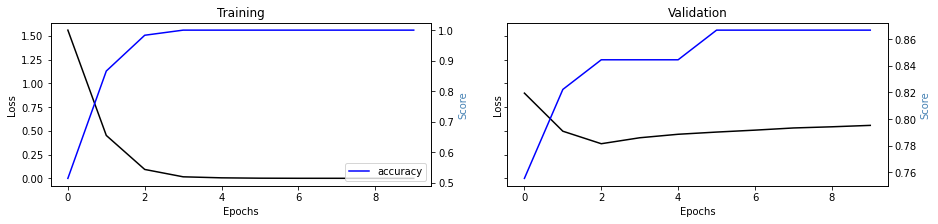

Iteração: 10 Fold: 2 Accuracy: 0.875, Mean Accuracy: 0.8660714285714286
Epoch 1/10
23/23 [==============================] - 7s 109ms/step - loss: 1.7581 - accuracy: 0.4729 - val_loss: 1.0781 - val_accuracy: 0.6222
Epoch 2/10
23/23 [==============================] - 1s 58ms/step - loss: 0.5884 - accuracy: 0.8872 - val_loss: 0.8265 - val_accuracy: 0.7111
Epoch 3/10
23/23 [==============================] - 1s 62ms/step - loss: 0.1169 - accuracy: 0.9824 - val_loss: 0.7202 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0364 - accuracy: 0.9993 - val_loss: 1.0851 - val_accuracy: 0.7333
Epoch 5/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0314 - accuracy: 0.9899 - val_loss: 0.9647 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 60ms/step - loss: 0.0192 - accuracy: 0.9956 - val_loss: 1.1554 - val_accuracy: 0.7556
Epoch 7/10
23/23 [==============================] - 1s 61ms/step - loss: 0.0163 -

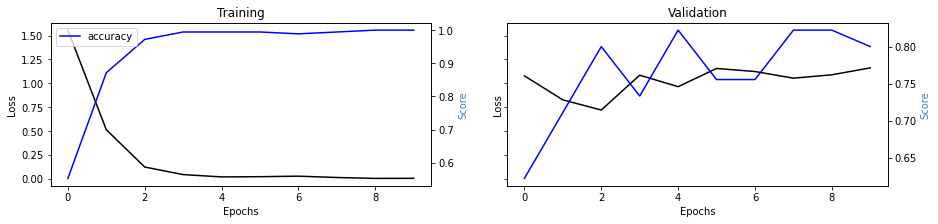

Iteração: 10 Fold: 3 Accuracy: 0.8928571428571429, Mean Accuracy: 0.875
Epoch 1/10
23/23 [==============================] - 7s 108ms/step - loss: 1.7566 - accuracy: 0.3675 - val_loss: 1.1463 - val_accuracy: 0.6000
Epoch 2/10
23/23 [==============================] - 1s 56ms/step - loss: 0.3725 - accuracy: 0.9196 - val_loss: 0.8468 - val_accuracy: 0.7333
Epoch 3/10
23/23 [==============================] - 1s 64ms/step - loss: 0.1199 - accuracy: 0.9754 - val_loss: 0.8713 - val_accuracy: 0.8000
Epoch 4/10
23/23 [==============================] - 1s 61ms/step - loss: 0.0202 - accuracy: 0.9960 - val_loss: 0.9224 - val_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0293 - accuracy: 0.9938 - val_loss: 0.9215 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.9637 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0021 -

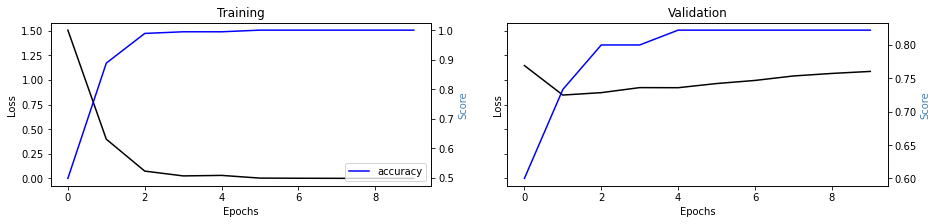

Iteração: 10 Fold: 4 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8660714285714286
Epoch 1/10
23/23 [==============================] - 9s 110ms/step - loss: 1.7218 - accuracy: 0.3801 - val_loss: 0.9049 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 59ms/step - loss: 0.4673 - accuracy: 0.8716 - val_loss: 0.5885 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0882 - accuracy: 0.9956 - val_loss: 0.5038 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 60ms/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.4563 - val_accuracy: 0.8889
Epoch 5/10
23/23 [==============================] - 1s 62ms/step - loss: 0.0488 - accuracy: 0.9837 - val_loss: 0.4690 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 62ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4858 - val_accuracy: 0.8889
Epoch 7/10
23/23 [==============================] - 1s 60ms/step - l

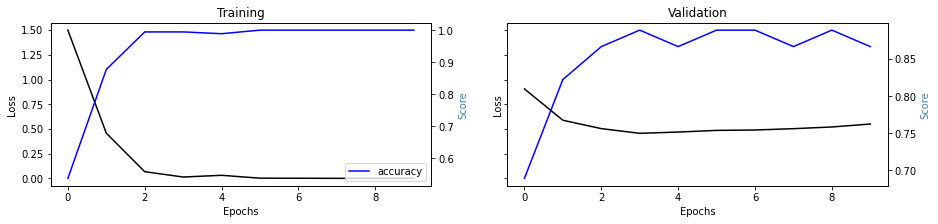

Iteração: 10 Fold: 5 Accuracy: 0.9464285714285714, Mean Accuracy: 0.8821428571428571
Epoch 1/10
23/23 [==============================] - 7s 108ms/step - loss: 1.7395 - accuracy: 0.4528 - val_loss: 0.8920 - val_accuracy: 0.6889
Epoch 2/10
23/23 [==============================] - 1s 54ms/step - loss: 0.4992 - accuracy: 0.8560 - val_loss: 0.4842 - val_accuracy: 0.8444
Epoch 3/10
23/23 [==============================] - 1s 62ms/step - loss: 0.1508 - accuracy: 0.9663 - val_loss: 0.4031 - val_accuracy: 0.8444
Epoch 4/10
23/23 [==============================] - 1s 62ms/step - loss: 0.0473 - accuracy: 0.9912 - val_loss: 0.3205 - val_accuracy: 0.8444
Epoch 5/10
23/23 [==============================] - 1s 61ms/step - loss: 0.0123 - accuracy: 0.9985 - val_loss: 0.3723 - val_accuracy: 0.8444
Epoch 6/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0411 - accuracy: 0.9658 - val_loss: 0.3272 - val_accuracy: 0.8444
Epoch 7/10
23/23 [==============================] - 1s 60ms/step - l

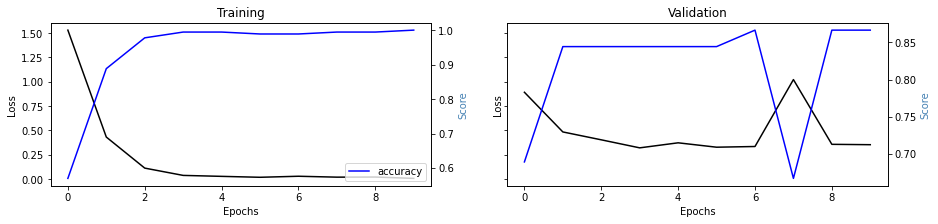

Iteração: 10 Fold: 6 Accuracy: 0.875, Mean Accuracy: 0.8809523809523809
Epoch 1/10
23/23 [==============================] - 7s 112ms/step - loss: 1.6983 - accuracy: 0.3666 - val_loss: 0.9258 - val_accuracy: 0.6667
Epoch 2/10
23/23 [==============================] - 1s 58ms/step - loss: 0.5385 - accuracy: 0.8514 - val_loss: 0.4184 - val_accuracy: 0.8667
Epoch 3/10
23/23 [==============================] - 1s 56ms/step - loss: 0.1011 - accuracy: 0.9874 - val_loss: 0.3404 - val_accuracy: 0.8667
Epoch 4/10
23/23 [==============================] - 1s 56ms/step - loss: 0.0342 - accuracy: 0.9894 - val_loss: 0.3444 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0761 - accuracy: 0.9788 - val_loss: 0.2105 - val_accuracy: 0.9556
Epoch 6/10
23/23 [==============================] - 1s 61ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.2063 - val_accuracy: 0.9333
Epoch 7/10
23/23 [==============================] - 1s 62ms/step - loss: 0.0055 -

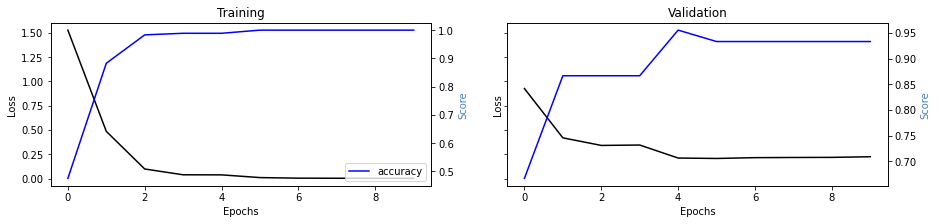

Iteração: 10 Fold: 7 Accuracy: 0.9464285714285714, Mean Accuracy: 0.8903061224489796
Epoch 1/10
23/23 [==============================] - 7s 100ms/step - loss: 1.7724 - accuracy: 0.2993 - val_loss: 1.0399 - val_accuracy: 0.7778
Epoch 2/10
23/23 [==============================] - 1s 53ms/step - loss: 0.5174 - accuracy: 0.9227 - val_loss: 0.5510 - val_accuracy: 0.8222
Epoch 3/10
23/23 [==============================] - 1s 59ms/step - loss: 0.1645 - accuracy: 0.9559 - val_loss: 0.4578 - val_accuracy: 0.8222
Epoch 4/10
23/23 [==============================] - 1s 55ms/step - loss: 0.0553 - accuracy: 0.9965 - val_loss: 0.3756 - val_accuracy: 0.8667
Epoch 5/10
23/23 [==============================] - 1s 54ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.3850 - val_accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3822 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 1s 55ms/step - l

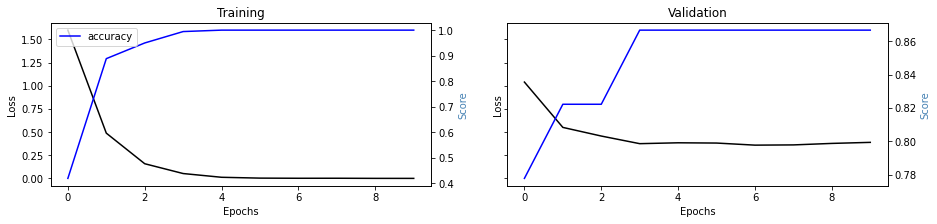

Iteração: 10 Fold: 8 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8928571428571428
Epoch 1/10
23/23 [==============================] - 7s 107ms/step - loss: 1.7612 - accuracy: 0.3619 - val_loss: 1.0739 - val_accuracy: 0.5778
Epoch 2/10
23/23 [==============================] - 1s 58ms/step - loss: 0.4478 - accuracy: 0.8948 - val_loss: 0.9557 - val_accuracy: 0.5778
Epoch 3/10
23/23 [==============================] - 1s 56ms/step - loss: 0.1973 - accuracy: 0.9263 - val_loss: 0.7842 - val_accuracy: 0.6889
Epoch 4/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0247 - accuracy: 0.9988 - val_loss: 0.3816 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 57ms/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.5103 - val_accuracy: 0.7556
Epoch 6/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0161 - accuracy: 0.9931 - val_loss: 0.5256 - val_accuracy: 0.7778
Epoch 7/10
23/23 [==============================] - 1s 57ms/step - l

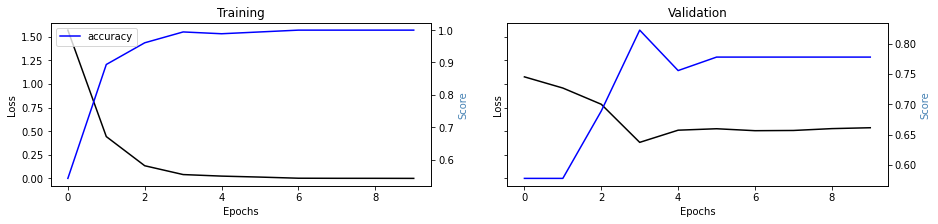

Iteração: 10 Fold: 9 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8829365079365079
Epoch 1/10
23/23 [==============================] - 7s 106ms/step - loss: 1.7380 - accuracy: 0.3606 - val_loss: 0.9888 - val_accuracy: 0.7111
Epoch 2/10
23/23 [==============================] - 1s 57ms/step - loss: 0.6100 - accuracy: 0.8560 - val_loss: 0.6931 - val_accuracy: 0.7778
Epoch 3/10
23/23 [==============================] - 1s 58ms/step - loss: 0.1212 - accuracy: 0.9817 - val_loss: 0.6494 - val_accuracy: 0.7778
Epoch 4/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0350 - accuracy: 0.9899 - val_loss: 0.6911 - val_accuracy: 0.8222
Epoch 5/10
23/23 [==============================] - 1s 61ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.7234 - val_accuracy: 0.8222
Epoch 6/10
23/23 [==============================] - 1s 59ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.7486 - val_accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 1s 56ms/step - l

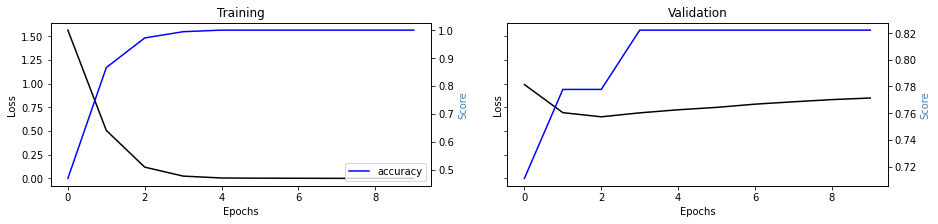

Iteração: 10 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8767857142857143


In [46]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    fold=0
#     conf_matrix_list_of_arrays = []

    k=10
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):

        fold +=1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=True, 
                                                            model=None, epochs=10, batch_size=8)
        # Validade Test Set
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays.append(conf_matrix)
        #
        accrs.append(accr)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

In [47]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.8748214285714286


### Evaluate

#### Plot Metrics Resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Setup Files         	       1.0	      0.86	      0.92	      0.92	      0.93
Requirement Document	       1.0	      0.88	      0.93	      0.92	      0.94
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	      0.88	      0.88	      0.88	      0.85	      0.93
Release Notes       	      0.78	       1.0	      0.88	      0.86	      0.98

Micro Average       	      0.94	      0.94	      0.94	      0.92	      0.97
Macro Average       	      0.95	      0.94	      0.94	      0.94	      0.97


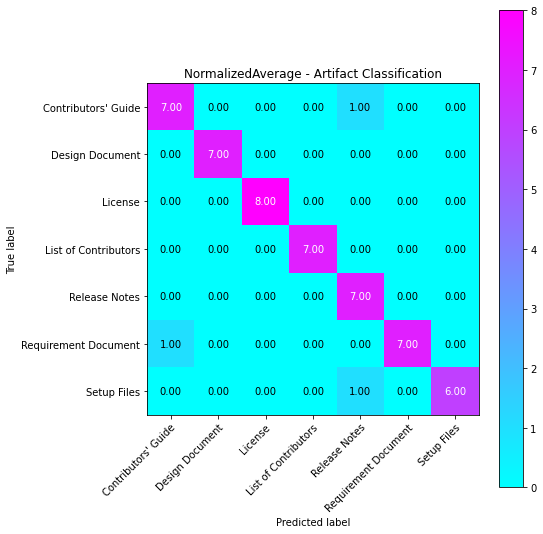

In [48]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## Word2Vec with Conventional Machine Learning

### Create the Feature Vector With Word2Vec

In [49]:
class Word2VecVectorizer:
  def __init__(self, word_vect):
    print("Loading in word vectors...")
    self.word_vectors = word_vect
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    # print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

### Vectorization

In [50]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(word_vect)
# Get the sentence embeddings for the train and test datasets
X = corpus

y = df["Label"].values

# Use for mNB
from sklearn.preprocessing import MinMaxScaler, normalize
def normalizer(X):
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    normalized_X = normalize(scaled_X, norm='max', axis=0, copy=True)
    return(normalized_X)

Loading in word vectors...
Finished loading in word vectors


In [51]:
def encode_y_train(y_train):
    vectorizer = LabelEncoder()
    y_train = vectorizer.fit_transform(y_train)
    return y_train

### Cross Validation and Fitting the Model

In [52]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y))}

In [62]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB

        y_train=encode_y_train(y_train)

        # train classifier
        model = nb.fit(X_train, y_train)
        # test
        predicted_prob = model.predict_proba(X_test)
        predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
                 predicted_prob]
    #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accr = metrics.accuracy_score(y_test, predicted)
        accrs.append(accr)
        preds.append(predicted)

    print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 2 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 3 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 4 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 5 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 6 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 7 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 8 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
-------------------------------------------
Iteração: 9 Fold: 10 Accuracy: 0.75, Mean Accuracy: 0.7285714285714285
---------

In [63]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.7285714285714285


### Evaluate

#### Plot Metrics Resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       0.5	      0.71	      0.59	      0.52	       0.8
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Setup Files         	       0.6	      0.86	      0.71	      0.67	      0.89
Requirement Document	       0.8	      0.57	      0.67	      0.64	      0.77
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	      0.83	      0.62	      0.71	      0.68	       0.8
Release Notes       	      0.86	      0.67	      0.75	      0.71	      0.82

Micro Average       	      0.77	      0.77	      0.77	      0.67	      0.87
Macro Average       	       0.8	      0.78	      0.78	      0.75	      0.87


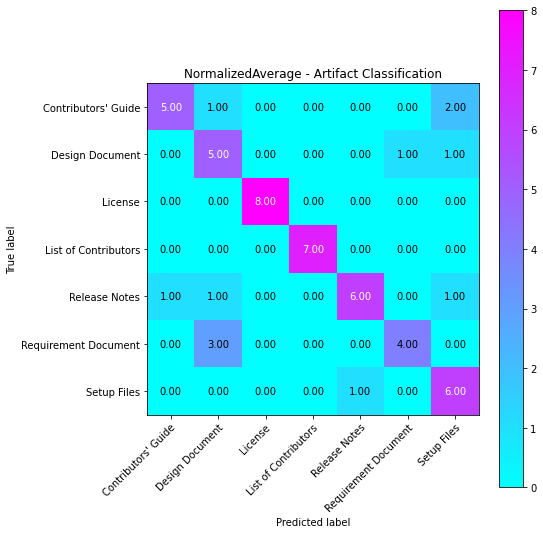

In [64]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [69]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    # conf_matrix_list_of_arrays = []
    k=10
    fold = 0
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB

        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}

        model = VotingClassifier(estimators=[
            ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[2,1,1,1])
        model = model.fit(X_train, y_train)

        predicted = model.predict(X_test)
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
        #    
        accrs.append(accr)
    #     print(metrics.classification_report(y_test, predicted))

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 1 Accuracy: 0.75, Mean Accuracy: 0.75
Iteração: 1 Fold: 2 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7321428571428572
Iteração: 1 Fold: 3 Accuracy: 0.8035714285714286, Mean Accuracy: 0.755952380952381
Iteração: 1 Fold: 4 Accuracy: 0.75, Mean Accuracy: 0.7544642857142858
Iteração: 1 Fold: 5 Accuracy: 0.75, Mean Accuracy: 0.7535714285714287
Iteração: 1 Fold: 6 Accuracy: 0.8214285714285714, Mean Accuracy: 0.7648809523809524
Iteração: 1 Fold: 7 Accuracy: 0.8392857142857143, Mean Accuracy: 0.7755102040816327
Iteração: 1 Fold: 8 Accuracy: 0.6964285714285714, Mean Accuracy: 0.765625
Iteração: 1 Fold: 9 Accuracy: 0.6785714285714286, Mean Accuracy: 0.7559523809523809
Iteração: 1 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.7625
Iteração: 2 Fold: 1 Accuracy: 0.75, Mean Accuracy: 0.75
Iteração: 2 Fold: 2 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7321428571428572
Iteração: 2 Fold: 3 Accuracy: 0.8035714285714286, Mean Accuracy: 0.755952380952381
Iteração: 2 Fol

In [70]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.7625000000000001


### Evaluate

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	      0.64	      0.88	      0.74	      0.69	      0.89
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Setup Files         	      0.54	       1.0	       0.7	      0.68	      0.93
Requirement Document	       1.0	      0.43	       0.6	      0.63	      0.71
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	       1.0	      0.57	      0.73	      0.73	      0.79
Release Notes       	       1.0	      0.75	      0.86	      0.85	      0.88

Micro Average       	      0.81	      0.81	      0.81	      0.68	      0.89
Macro Average       	      0.88	       0.8	       0.8	       0.8	      0.89


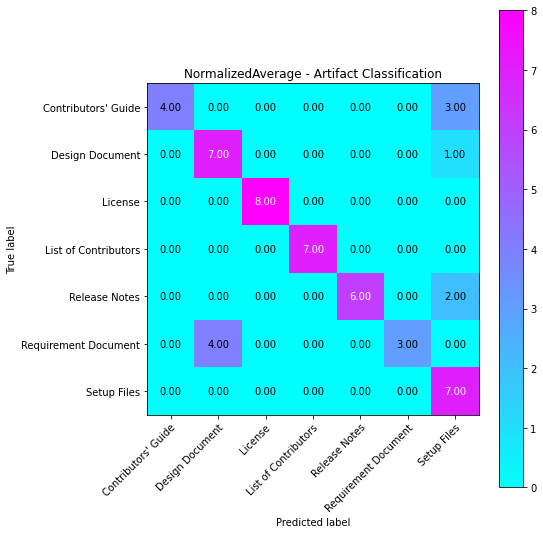

In [71]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))